In [1]:
# Import all the functions you need
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
from pathlib import Path
import platform

# Comment here to add in for either mac or linux computer
if platform.system() == "Linux":   # for linux
    sys.path.extend(['/data/GitHub/NeuroPy']) 
    sys.path.extend(['/data/GitHub/TraceFC/'])
elif platform.system() == "Darwin":
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/TraceFC'])
elif platform.system() == "Windows":
    print('No windows repositories defined')

from neuropy import core
from neuropy.io import (optitrackio,
                        dlcio,
                        )
from neuropy.io.miniscopeio import MiniscopeIO
from neuropy.core import Epoch
from neuropy.utils import plot_util
from neuropy.utils.signal_process import WaveletSg
from neuropy.plotting.spikes import plot_raster, plot_binned_raster
from neuropy.plotting.signals import plot_signal_w_epochs, plot_spectrogram

from tracefc.io.session_directory import get_session_dir


In [2]:
# Define a class for a typical recording or set of recordings
from neuropy.core.session import ProcessData
    
def sess_use(basepath=os.getcwd()):

    return ProcessData(basepath)

In [3]:
animal, sess_name = 'Finn2', 'training'
sess_dir = get_session_dir(animal, sess_name)
sess = sess_use(sess_dir)
print(sess.recinfo)

filename: /data3/Trace_FC/Recording_Rats/Finn2/2023_05_08_training/Finn2_training_denoised.xml 
# channels: 35
sampling rate: 30000
lfp Srate (downsampled): 1250



In [4]:
print(sess.eegfile)

duration: 19024.80 seconds 
duration: 5.28 hours 



# Preprocess Ephys data
Identify artifacts:  
- disconnects  
- filtering  
  
Send to event files to check in Neuroscope  
Write `dead_times.txt` file for spyking-circus and `artifacts.npy` file for my own analysis.

### Identify disconnect and motion artifacts

In [5]:
from neuropy.analyses.artifact import detect_artifact_epochs
signal = sess.eegfile.get_signal()
buffer_add = 0.25  # seconds, None = don't add

art_epochs_file = sess.filePrefix.with_suffix(".art_epochs.npy")
if art_epochs_file.exists():
    art_epochs = Epoch(epochs=None, file=art_epochs_file)
    print('Existing artifact epochs file loaded')
else:
    # art_epochs = detect_artifact_epochs(signal, thresh=8, 
    #                                 edge_cutoff=3, merge=6)

    # Pick a particular channel with the code below
    art_epochs = detect_artifact_epochs(signal.time_slice(channel_id=26), thresh=8, 
                                    edge_cutoff=3, merge=6)

    if buffer_add is not None:  # Add in buffer to prevent erroneous detection of start/stop of artifact as SWRs
        art_epochs.add_epoch_buffer(buffer_add)
    sess.recinfo.write_epochs(epochs=art_epochs, ext='art')
    art_epochs.save(art_epochs_file)

print(f'Total artifact time = {art_epochs.durations.sum():0.1F} seconds')
art_epochs.to_dataframe()

Existing artifact epochs file loaded
Total artifact time = 45.6 seconds


/home/bowenw/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


start        stop label  duration
0     650.5812    651.1516          0.5704
1     823.7372    824.5060          0.7688
2     854.9204    855.7524          0.8320
3     880.9212    881.6164          0.6952
4    1036.9284   1038.4908          1.5624
5    1296.6212   1298.4532          1.8320
6    1578.6364   1580.2220          1.5856
7    1853.5348   1855.0572          1.5224
8    2123.3764   2124.9532          1.5768
9    2382.0612   2383.6300          1.5688
10   8236.4020   8245.6948          9.2928
11   8605.2860   8606.0452          0.7592
12  11599.4724  11620.3724         20.9000
13  14036.4684  14037.0052          0.5368
14  14412.7612  14413.3044          0.5432
15  16889.6812  16890.2252          0.5440
16  18810.5092  18811.0500          0.5408

<Axes: >

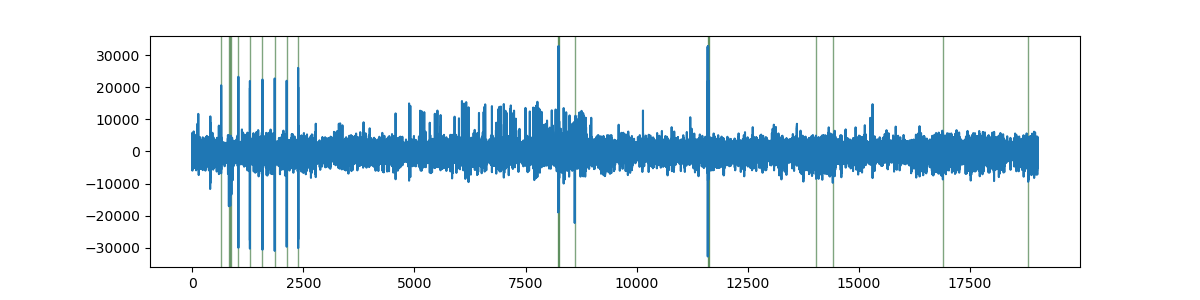

In [6]:
%matplotlib widget

chan_plot = 25
plot_signal_w_epochs(signal, chan_plot, art_epochs)

## Define probe group

/data3/Trace_FC/Recording_Rats/Finn2/2023_05_08_training/Finn2_training_denoised.probegroup.npy saved


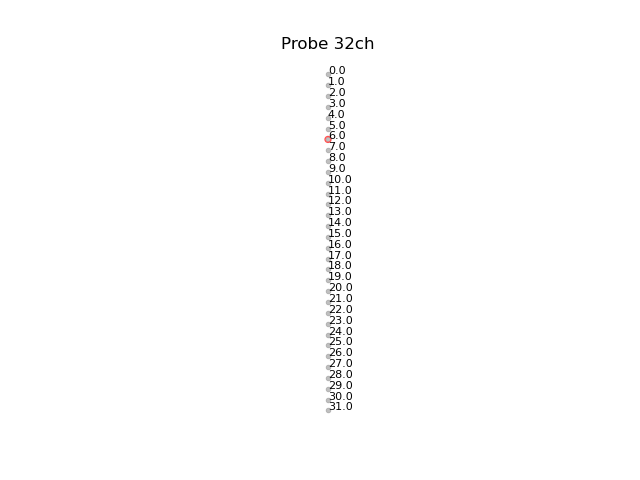

In [7]:
from neuropy.core import Shank, Probe, ProbeGroup
from neuropy.plotting import plot_probe
shank = Shank()
shank = shank.auto_generate(columns=1, contacts_per_column=32, xpitch=0,
                   ypitch=50, channel_id=np.arange(31, -1, -1))
shank.set_disconnected_channels(sess.recinfo.skipped_channels)
probe = Probe(shank)
prbgrp = ProbeGroup()
prbgrp.add_probe(probe)
plot_probe(prbgrp)
prbgrp.filename = sess.filePrefix.with_suffix(".probegroup.npy")
prbgrp.save(prbgrp.filename)
sess.prbgrp = prbgrp

# Detect Theta epochs

In [8]:
from neuropy.analyses.oscillations import detect_theta_epochs
mindur=1
maxdur=20
thresh = (1, None)
sigma = 0.125
edge_cutoff = 0.25
theta_channel = 7

# use this if you don't know theta channel
if theta_channel is None:
    theta_epochs, theta_power = detect_theta_epochs(signal, prbgrp, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
else:
    signal_use = signal.time_slice(channel_id=theta_channel)
    theta_epochs, theta_power = detect_theta_epochs(signal_use, probegroup=None, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
sess.recinfo.write_epochs(theta_epochs, ext='tha')
theta_epochs_file = sess.filePrefix.with_suffix(".theta_epochs.npy")
theta_epochs.save(theta_epochs_file)

Best channel for theta: [7]
1502 epochs remaining with durations within (1,20)
/data3/Trace_FC/Recording_Rats/Finn2/2023_05_08_training/Finn2_training_denoised.theta_epochs.npy saved


<Axes: >

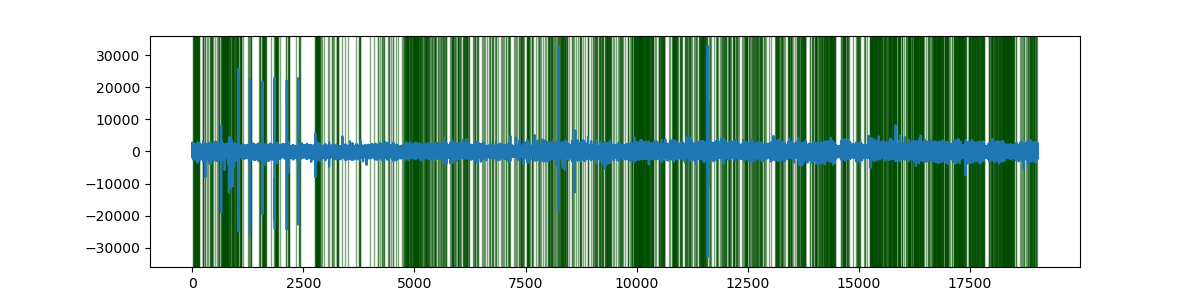

In [9]:
%matplotlib widget

chan_plot = theta_channel
plot_signal_w_epochs(signal, chan_plot, theta_epochs)

In [10]:
from neuropy.utils.signal_process import hilbert_amplitude_stat, theta_phase_specfic_extraction, ThetaParams

## Waveshape to detect peaks and troughs

In [11]:
tparams = ThetaParams(lfp=signal.traces[theta_channel, :], fs=signal.sampling_rate, method="waveshape")
trough_indices = tparams.trough.astype(int)
peak_indices = tparams.peak.astype(int)

(-4000.0, 4000.0)

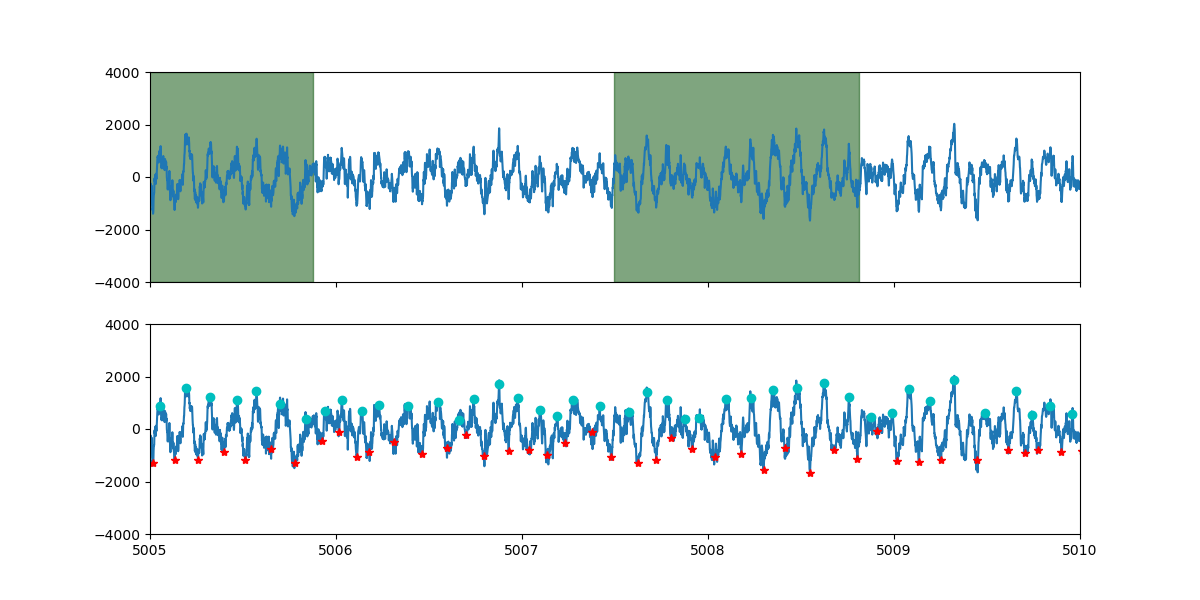

In [12]:
_, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True, sharey=True)
plot_signal_w_epochs(signal, chan_plot, theta_epochs, ax=ax[0])
ax[1].plot(signal.time, signal.traces[theta_channel])

ax[1].plot(signal.time[trough_indices], signal.traces[theta_channel, trough_indices], 'r*')
ax[1].plot(signal.time[peak_indices], signal.traces[theta_channel, peak_indices], 'co')

ax[0].set_xlim((5005, 5010))
ax[1].set_ylim((-4000, 4000))

## Read in USV epochs

In [13]:
# Import USV epochs (from Sync_USV_and_Ephys notebook).
usv_epochs_file = sess.filePrefix.with_suffix(".usv_epochs.npy")
usv_epochs = Epoch(epochs=None, file=usv_epochs_file)
usv_epochs

457 epochs
Snippet: 
         start        stop  Begin_Time   Freq_Min  Duration  Freq_Range  Score  \
0  652.529394  652.563925   37.946853  39.274313  0.034535   20.924947    1.0   
1  652.676857  652.722485   38.094337  40.405391  0.045634   18.889006    1.0   
2  653.508978  653.542528   38.926574  46.196915  0.033555   12.441860    1.0   
3  655.169906  655.224620   40.587737  39.726744  0.054721   17.418605    1.0   
4  656.243937  656.292611   41.661918  37.917019  0.048681   41.171247    1.0   

   Accept label  
0       1        
1       1        
2       1        
3       1        
4       1        

## all USV Theta phase plots

<Axes: ylabel='Count'>

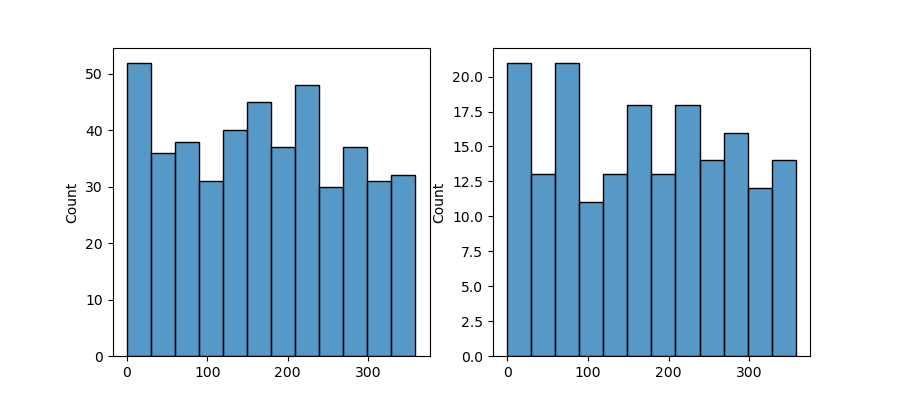

In [14]:
# First get frame number of each usv.
usv_start_frames = (usv_epochs.starts * tparams.fs).astype(int)
usv_start_frames

# Get theta power for each call start
# high_theta_usv_start_times = theta_epochs.contains(usv_epochs.starts)  # This might be too conservative
usv_start_theta_power = theta_power[usv_start_frames]

# Only include calls with above average theta power
theta_thresh = 0  # units = std (theta power is z-scored)
highusv_power_bool = usv_start_theta_power > theta_thresh
high_theta_usv_start_frames = usv_start_frames[highusv_power_bool]

# Next, calculate theta phase angle at each usv start
phase_start = tparams.angle[usv_start_frames]
high_theta_phase_start = tparams.angle[high_theta_usv_start_frames]

# Plot histogram of usv start angles
_, ax = plt.subplots(1, 2, figsize=(9, 4))
sns.histplot(phase_start, binwidth=30, ax=ax[0])
sns.histplot(high_theta_phase_start, binwidth=30, ax=ax[1])


In [15]:
import numpy as np
import seaborn as sns

## low USV theta phase plots

<Axes: ylabel='Count'>

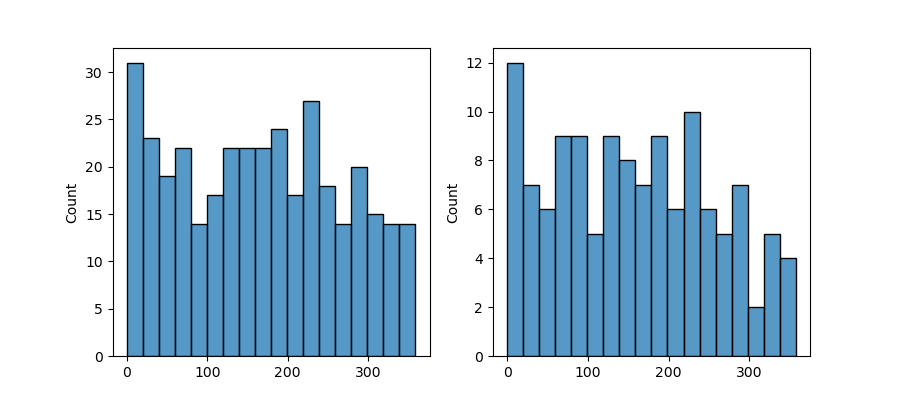

In [16]:
#Histogram for low USVs
# First get frame number of each usv.
lowusv_epochs = usv_epochs._epochs[usv_epochs._epochs.Freq_Min<=23]
lowusv_epochs
lowusv_start_frames = (lowusv_epochs.start * tparams.fs).astype(int)
lowusv_start_frames

# Get theta power for each call start
# high_theta_usv_start_times = theta_epochs.contains(usv_epochs.starts)  # This might be too conservative
lowusv_start_theta_power = theta_power[lowusv_start_frames]

# Only include calls with above average theta power
theta_thresh = 0  # units = std (theta power is z-scored)
lowusv_high_usv_power_bool = lowusv_start_theta_power > theta_thresh
lowusv_high_theta_usv_start_frames = lowusv_start_frames[lowusv_high_usv_power_bool]

# Next, calculate theta phase angle at each usv start
lowusv_phase_start = tparams.angle[lowusv_start_frames]
lowusv_high_theta_phase_start = tparams.angle[lowusv_high_theta_usv_start_frames]

# Plot histogram of usv start angles
_, ax = plt.subplots(1, 2, figsize=(9, 4))
sns.histplot(lowusv_phase_start, binwidth=20, ax=ax[0])
sns.histplot(lowusv_high_theta_phase_start, binwidth=20, ax=ax[1])

## high USV theta phase plots

<Axes: ylabel='Count'>

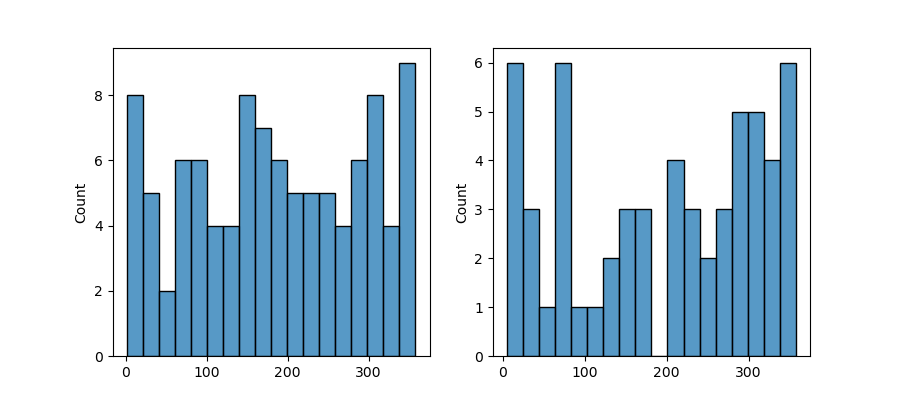

In [17]:
#Histogram for high USVs
# First get frame number of each usv.
highusv_epochs = usv_epochs._epochs[usv_epochs._epochs.Freq_Min>23]
highusv_epochs
highusv_start_frames = (highusv_epochs.start * tparams.fs).astype(int)
highusv_start_frames

# Get theta power for each call start
# high_theta_usv_start_times = theta_epochs.contains(usv_epochs.starts)  # This might be too conservative
highusv_start_theta_power = theta_power[highusv_start_frames]

# Only include calls with above average theta power
theta_thresh = 0  # units = std (theta power is z-scored)
highusv_high_usv_power_bool = highusv_start_theta_power > theta_thresh
highusv_high_theta_usv_start_frames = highusv_start_frames[highusv_high_usv_power_bool]

# Next, calculate theta phase angle at each usv start
highusv_phase_start = tparams.angle[highusv_start_frames]
highusv_high_theta_phase_start = tparams.angle[highusv_high_theta_usv_start_frames]

# Plot histogram of usv start angles
_, ax = plt.subplots(1, 2, figsize=(9, 4))
sns.histplot(highusv_phase_start, binwidth=20, ax=ax[0])
sns.histplot(highusv_high_theta_phase_start, binwidth=20, ax=ax[1])

In [18]:
highusv_high_theta_phase_start

array([310.53435115, 260.74766355, 339.71830986, 238.46153846,
       327.27272727, 345.6       , 305.05263158, 289.28571429,
       178.        , 245.85365854, 231.        ,  62.41935484,
        72.53731343,  19.51807229, 210.24      , 317.52808989,
       311.29411765, 152.83018868, 296.07476636,   5.85365854,
       353.68421053, 357.35294118, 133.33333333, 239.0625    ,
        36.        ,  17.14285714, 134.57943925, 168.29268293,
       337.77777778, 332.54237288,  68.27586207,  36.48648649,
       117.24324324,  82.5       , 289.48453608, 295.13513514,
        68.18181818,  31.09090909, 321.52671756, 300.        ,
        15.84      , 159.75      , 180.        , 279.81818182,
        80.16806723, 255.        , 154.28571429, 348.11320755,
       277.62711864, 217.89473684,  10.        ,  23.47826087,
       356.4       , 202.5       ,  86.4       , 211.76470588,
       261.        ,  81.39130435])

In [72]:

time_points = np.arange(signal.t_start, signal.t_stop, 1/signal.sampling_rate)

t_start = 0  
t_stop = 12444.16  
sampling_rate = 1250  

low_usv_bool = np.zeros(len(time_points), dtype=bool)

start_times = lowusv_epochs['start'].to_numpy()
stop_times = lowusv_epochs['stop'].to_numpy()

for start, stop in zip(start_times, stop_times):
    start_idx = np.searchsorted(time_points, start, side='left')
    stop_idx = np.searchsorted(time_points, stop, side='right')
    start_idx = max(start_idx, 0)
    stop_idx = min(stop_idx, len(time_points))
    low_usv_bool[start_idx:stop_idx] = True


In [73]:
signal.t_stop

19024.8024

In [74]:
signal.sampling_rate

1250

In [75]:
low_usv_theta_power = theta_power[low_usv_bool]
low_usv_theta_mean = low_usv_theta_power.mean()
low_usv_theta_std = low_usv_theta_power.std()

non_low_usv_theta_power = theta_power[~low_usv_bool]
non_low_usv_theta_mean = non_low_usv_theta_power.mean()
non_low_usv_theta_std = non_low_usv_theta_power.std()


In [76]:
low_usv_theta_power

array([-0.29175721, -0.29496645, -0.29820506, ...,  0.2499184 ,
        0.24970543,  0.24948099])

## high/low USV and theta epoch plot

/tmp/ipykernel_1389730/1712637166.py:22: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = Rectangle((start_time, 0.7), duration, 0.3, color='darkblue', edgecolor='none', alpha=0.7)
/tmp/ipykernel_1389730/1712637166.py:31: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = Rectangle((start_time, 0.4), duration, 0.3, color='lightblue', edgecolor='none', alpha=0.5)
/tmp/ipykernel_1389730/1712637166.py:37: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = Rectangle((start_time, 0.1), duration, 0.3, color='green', edgecolor='none', alpha=0.5)


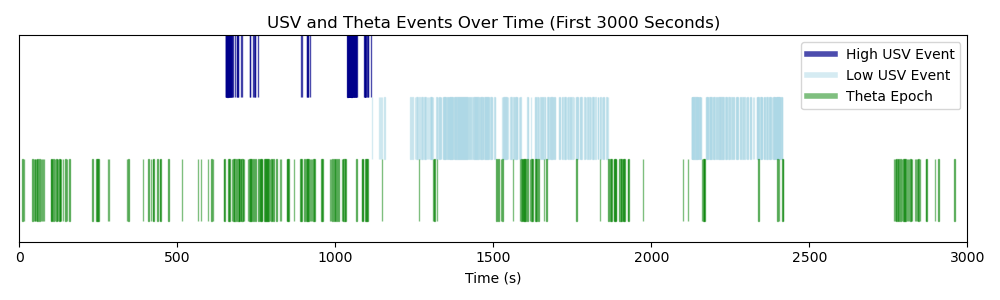

In [23]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

# Assuming theta_epochs are defined elsewhere
theta_start_times = theta_epochs.starts
theta_stop_times = theta_epochs.stops
theta_durations = theta_stop_times - theta_start_times

usv_start_times = usv_epochs.starts
usv_stop_times = usv_epochs.stops
usv_durations = usv_epochs.stops - usv_epochs.starts

fig, ax = plt.subplots(figsize=(10, 3))

# Plot high USV events in another color (now on top)
for _, row in highusv_epochs.iterrows():
    start_time = row['start']
    stop_time = row['stop']
    duration = stop_time - start_time
    if start_time <= 3000:  # Limit to the first 3000 seconds
        rect = Rectangle((start_time, 0.7), duration, 0.3, color='darkblue', edgecolor='none', alpha=0.7)
        ax.add_patch(rect)

# Plot low USV events in one color (now second from top)
for _, row in lowusv_epochs.iterrows():
    start_time = row['start']
    stop_time = row['stop']
    duration = stop_time - start_time
    if start_time <= 3000:  # Limit to the first 3000 seconds
        rect = Rectangle((start_time, 0.4), duration, 0.3, color='lightblue', edgecolor='none', alpha=0.5)
        ax.add_patch(rect)

# Plot Theta epochs (now third from top)
for start_time, duration in zip(theta_start_times, theta_durations):
    if start_time <= 3000:  # Limit to the first 3000 seconds
        rect = Rectangle((start_time, 0.1), duration, 0.3, color='green', edgecolor='none', alpha=0.5)
        ax.add_patch(rect)

# Customize the legend
custom_lines = [
    Line2D([0], [0], color='darkblue', lw=4, alpha=0.7),
    Line2D([0], [0], color='lightblue', lw=4, alpha=0.5),
    Line2D([0], [0], color='green', lw=4, alpha=0.5),
]
ax.legend(custom_lines, ['High USV Event', 'Low USV Event', 'Theta Epoch'])

# Adjust limits and labels
ax.set_xlim(0, 3000)  # Limit x-axis to the first 3000 seconds
ax.set_ylim(0, 1)  # Adjusted to accommodate all rows without overlapping
ax.set_xlabel('Time (s)')
ax.set_yticks([])
plt.title('USV and Theta Events Over Time (First 3000 Seconds)')
plt.tight_layout()
plt.show()

## Theta stop USV start CCG

In [24]:
from neuropy.utils.ccg import correlograms

# We observe that right after theta ends there seem to be a lot of USVs starting - check this by looking at CCG between theta off and
# USV onset times
theta_off_usv_on_times = [theta_epochs.stops, usv_epochs.starts]
theta_off_usv_on_ids = np.hstack([np.ones_like(array)*ida for ida, array in enumerate(theta_off_usv_on_times)])
theta_off_usv_on_times = np.hstack(theta_off_usv_on_times)
sort_ids = np.argsort(theta_off_usv_on_times)

theta_off_usv_on_times = theta_off_usv_on_times[sort_ids]
theta_off_usv_on_ids = theta_off_usv_on_ids[sort_ids].astype(int)

window_size = 10 # seconds
bin_size = 0.25 # seconds
ccg = correlograms(theta_off_usv_on_times, theta_off_usv_on_ids, sample_rate=30, window_size=window_size, bin_size=bin_size)

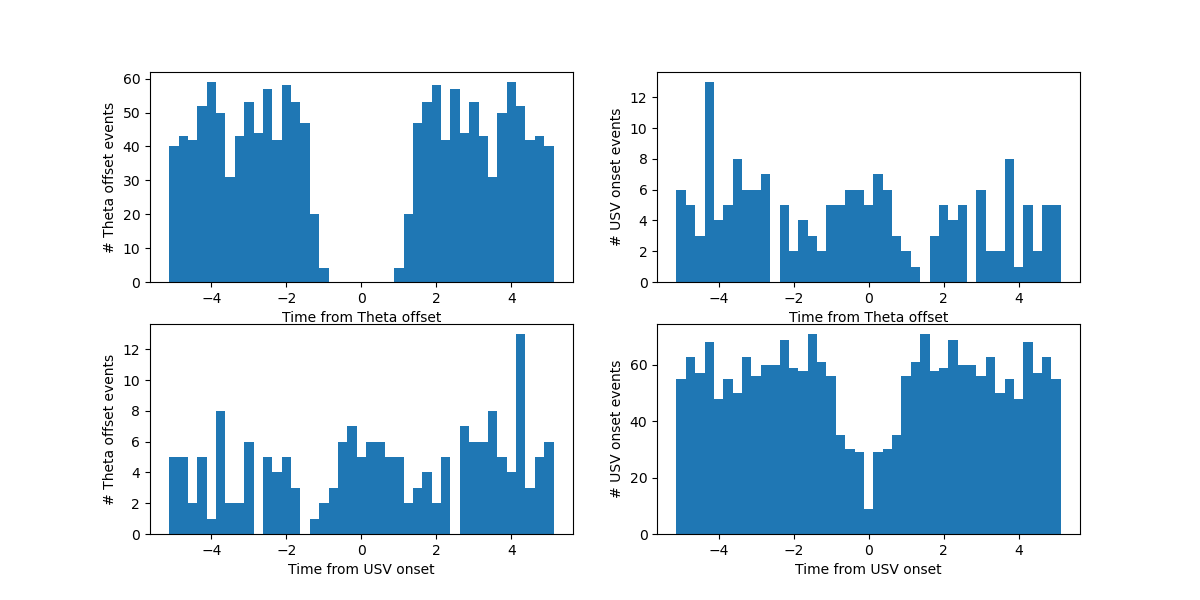

In [25]:
# Sample plotting code
time_bins = np.linspace(-window_size/2, window_size/2, np.array(window_size/bin_size + 1, dtype=int))
_, ax = plt.subplots(2, 2, figsize=(12, 6))

var_names = ['Theta offset', 'USV onset']
for idv, (a, ccg_use) in enumerate(zip(ax, ccg)):
    for ida2, (a2, ccg_use2) in enumerate(zip(a, ccg_use)): 
        a2.bar(time_bins, ccg_use2, width=bin_size)
        a2.set_xlabel(f"Time from {var_names[idv]}")
        a2.set_ylabel(f"# {var_names[ida2]} events")

Text(0, 0.5, '# USV onset events')

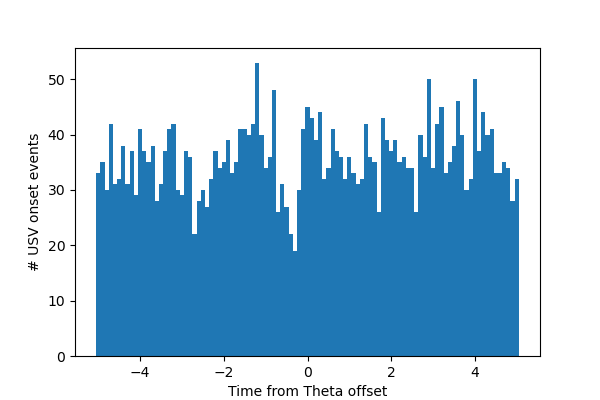

In [77]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(time_bins, ccg[0, 1], width=bin_size)
ax.set_xlabel(f"Time from Theta offset")
ax.set_ylabel(f"# USV onset events")

In [27]:
fig.savefig('/home/bowenw/Documents/thesisplots/testdefault.png', dpi=600)

## Ripple detection

In [28]:
from neuropy.analyses.oscillations import detect_ripple_epochs
ripple_channel = 7
thresh = (2, None)  # conservative but good
edge_cutoff = 0.5
exclude_theta_epochs = False  # make this true if you end up with a lot of false positive ripples as gamma events during theta

if not exclude_theta_epochs:
    ripple_epochs = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                         edge_cutoff=edge_cutoff, ignore_epochs=art_epochs)
else:
    ripple_epochs = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                         edge_cutoff=edge_cutoff,
                                         ignore_epochs=art_epochs.__add__(theta_epochs))
sess.recinfo.write_epochs(ripple_epochs, ext='swr')
ripple_epochs_file = sess.filePrefix.with_suffix(".ripple_epochs.npy")
ripple_epochs.save(ripple_epochs_file)

Selected channels for ripples: [7]
15273 epochs remaining with durations within (0.05,0.45)
/data3/Trace_FC/Recording_Rats/Finn2/2023_05_08_training/Finn2_training_denoised.ripple_epochs.npy saved


In [29]:
# Convert ripple epochs to binned ripple rate
t, rip_bool = ripple_epochs.to_point_process()
from neuropy.core.neurons import BinnedSpiketrain, Neurons
rips = Neurons(t[None, rip_bool], t_stop=50*60)

In [30]:
bin_size_sec = 1
binned_rips = rips.get_binned_spiketrains(bin_size=bin_size_sec)

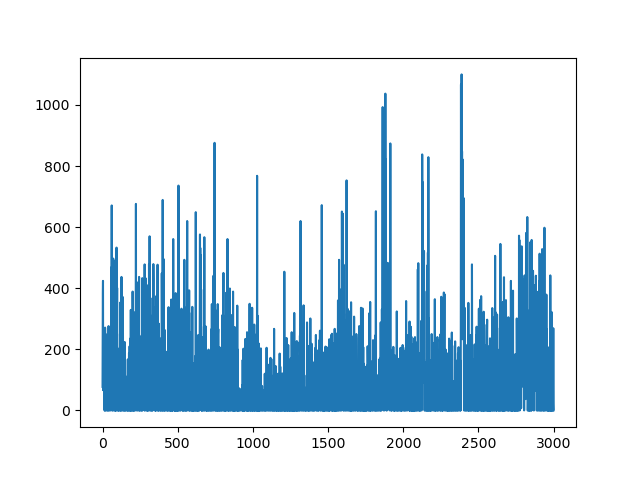

In [31]:
_, ax = plt.subplots()
ax.plot(binned_rips.time, binned_rips.firing_rate[0])

In [32]:
ripple_epochs

15273 epochs
Snippet: 
     start    stop  peak_time  peak_power label
0  0.9152  0.9744     0.9536    2.090172      
1  0.9984  1.1168     1.0632    2.116665      
2  1.7392  1.8384     1.7920    3.535054      
3  2.1648  2.2456     2.2168    2.352919      
4  2.6824  2.8184     2.7392    8.147441      

## high/low USV ripple epoch plot

/tmp/ipykernel_1389730/1711853227.py:22: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = Rectangle((start_time, 0.4), duration, 0.3, color='darkblue', edgecolor='none', alpha=0.7)
/tmp/ipykernel_1389730/1711853227.py:31: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = Rectangle((start_time, 0.4), duration, 0.3, color='lightblue', edgecolor='none', alpha=0.5)
/tmp/ipykernel_1389730/1711853227.py:37: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = Rectangle((start_time, 0.1), duration, 0.3, color='green', edgecolor='none', alpha=0.5)


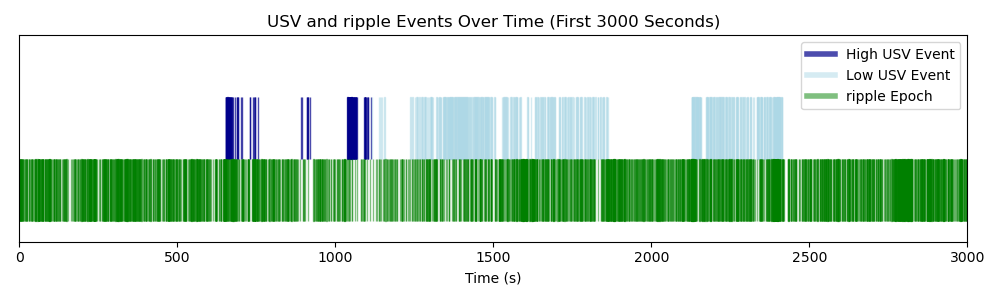

In [33]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

# Assuming ripple_epochs are defined elsewhere
ripple_start_times = ripple_epochs.starts
ripple_stop_times = ripple_epochs.stops
ripple_durations = ripple_stop_times - ripple_start_times

usv_start_times = usv_epochs.starts
usv_stop_times = usv_epochs.stops
usv_durations = usv_epochs.stops - usv_epochs.starts

fig, ax = plt.subplots(figsize=(10, 3))

# Plot high USV events in another color (now on top)
for _, row in highusv_epochs.iterrows():
    start_time = row['start']
    stop_time = row['stop']
    duration = stop_time - start_time
    if start_time <= 3000:  # Limit to the first 3000 seconds
        rect = Rectangle((start_time, 0.4), duration, 0.3, color='darkblue', edgecolor='none', alpha=0.7)
        ax.add_patch(rect)

# Plot low USV events in one color (now second from top)
for _, row in lowusv_epochs.iterrows():
    start_time = row['start']
    stop_time = row['stop']
    duration = stop_time - start_time
    if start_time <= 3000:  # Limit to the first 3000 seconds
        rect = Rectangle((start_time, 0.4), duration, 0.3, color='lightblue', edgecolor='none', alpha=0.5)
        ax.add_patch(rect)

# Plot ripple epochs (now third from top)
for start_time, duration in zip(ripple_start_times, ripple_durations):
    if start_time <= 3000:  # Limit to the first 3000 seconds
        rect = Rectangle((start_time, 0.1), duration, 0.3, color='green', edgecolor='none', alpha=0.5)
        ax.add_patch(rect)

# Customize the legend
custom_lines = [
    Line2D([0], [0], color='darkblue', lw=4, alpha=0.7),
    Line2D([0], [0], color='lightblue', lw=4, alpha=0.5),
    Line2D([0], [0], color='green', lw=4, alpha=0.5),
]
ax.legend(custom_lines, ['High USV Event', 'Low USV Event', 'ripple Epoch'])

# Adjust limits and labels
ax.set_xlim(0, 3000)  # Limit x-axis to the first 3000 seconds
ax.set_ylim(0, 1)  # Adjusted to accommodate all rows without overlapping
ax.set_xlabel('Time (s)')
ax.set_yticks([])
plt.title('USV and ripple Events Over Time (First 3000 Seconds)')
plt.tight_layout()
plt.show()

## Ripple stop USV start CCG

In [34]:
from neuropy.utils.ccg import correlograms

# We observe that right after ripple ends there seem to be a lot of USVs starting - check this by looking at CCG between ripple off and
# USV onset times
ripple_off_usv_on_times = [ripple_epochs.stops, usv_epochs.starts]
ripple_off_usv_on_ids = np.hstack([np.ones_like(array)*ida for ida, array in enumerate(ripple_off_usv_on_times)])
ripple_off_usv_on_times = np.hstack(ripple_off_usv_on_times)
sort_ids = np.argsort(ripple_off_usv_on_times)

ripple_off_usv_on_times = ripple_off_usv_on_times[sort_ids]
ripple_off_usv_on_ids = ripple_off_usv_on_ids[sort_ids].astype(int)

window_size = 10 # seconds
bin_size = 0.1 # seconds
ccg = correlograms(ripple_off_usv_on_times, ripple_off_usv_on_ids, sample_rate=30, window_size=window_size, bin_size=bin_size)

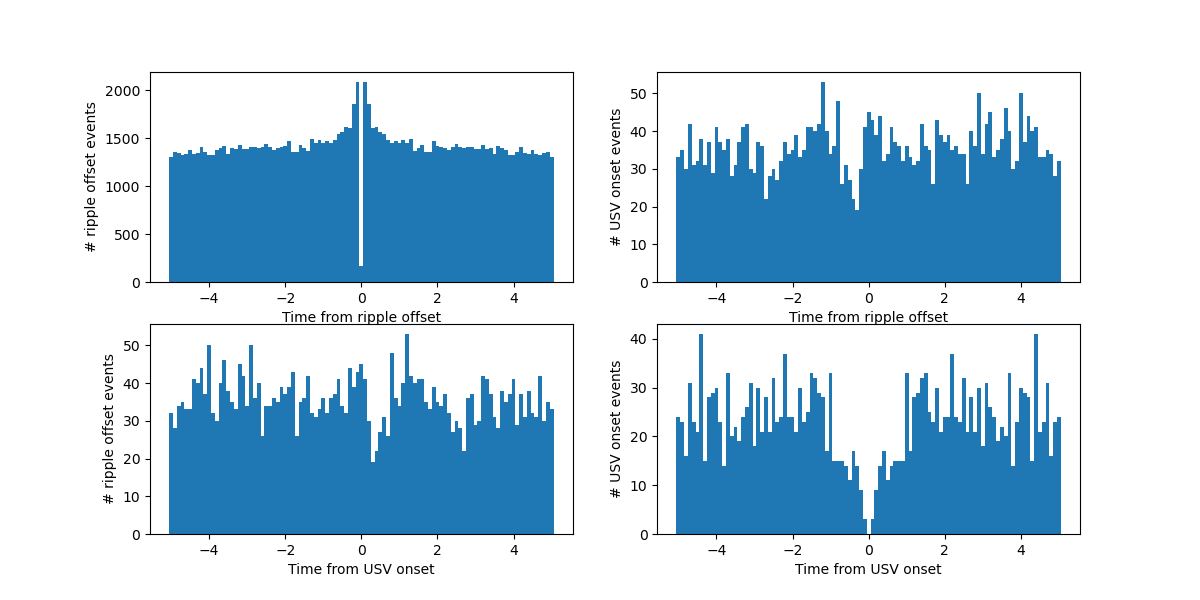

In [35]:
# Sample plotting code
time_bins = np.linspace(-window_size/2, window_size/2, np.array(window_size/bin_size + 1, dtype=int))
_, ax = plt.subplots(2, 2, figsize=(12, 6))

var_names = ['ripple offset', 'USV onset']
for idv, (a, ccg_use) in enumerate(zip(ax, ccg)):
    for ida2, (a2, ccg_use2) in enumerate(zip(a, ccg_use)): 
        a2.bar(time_bins, ccg_use2, width=bin_size)
        a2.set_xlabel(f"Time from {var_names[idv]}")
        a2.set_ylabel(f"# {var_names[ida2]} events")

## Theta power during lowUSV/highUSV

In [36]:
theta_power_sg = core.signal.Signal(theta_power, signal.sampling_rate)

In [37]:
recording_duration = 3000 
theta_power_usvs = []
theta_power_non_usvs = []
theta_power_highusvs = [] 
theta_power_lowusvs = []

for i, usv_epoch in enumerate(usv_epochs):
    if usv_epoch.stops > recording_duration:

        usv_epoch.stops = recording_duration
    

    if usv_epoch.to_dataframe()['Freq_Min'].values[0] > 23:

        power_slice = theta_power_sg.time_slice(t_start=usv_epoch.starts[0], t_stop=min(usv_epoch.stops[0], recording_duration))
        theta_power_highusvs.append(power_slice.traces[0].mean())
        
    if usv_epoch.to_dataframe()['Freq_Min'].values[0] < 23:

        power_slice = theta_power_sg.time_slice(t_start=usv_epoch.starts[0], t_stop=min(usv_epoch.stops[0], recording_duration))
        theta_power_lowusvs.append(power_slice.traces[0].mean())
         
theta_power_lowusvs= np.array(theta_power_lowusvs)
theta_power_highusvs = np.array(theta_power_highusvs)
theta_power_usvs = np.array(theta_power_usvs)
theta_power_non_usvs = np.array(theta_power_non_usvs)


df1 = pd.DataFrame({"Theta Power": theta_power_usvs, "Epoch": "USV"})
df2 = pd.DataFrame({"Theta Power": theta_power_lowusvs, "Epoch": "LowUSV"})
df3 = pd.DataFrame({"Theta Power": theta_power_highusvs, "Epoch": "HighUSV"})
df4 = pd.DataFrame({"Theta Power": theta_power_non_usvs, "Epoch": "non-USV"})
theta_power_df = pd.concat([df2, df3], axis=0).reset_index(drop=True)

theta_power_df

Theta Power    Epoch
0      -0.902422   LowUSV
1      -1.249937   LowUSV
2       0.007092   LowUSV
3      -0.282130   LowUSV
4      -0.485489   LowUSV
..           ...      ...
452    -0.278465  HighUSV
453     1.037206  HighUSV
454     1.394132  HighUSV
455     0.804420  HighUSV
456     1.178230  HighUSV

[457 rows x 2 columns]

/tmp/ipykernel_1389730/4024308678.py:3: RuntimeWarning: Mean of empty slice.
  title_text = f"Finn2: Theta power during usv and non_usv\nMean USV: {theta_power_usvs.mean():.4f}, Mean non-USV: {theta_power_non_usvs.mean():.4f}"
/home/bowenw/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


<Axes: title={'center': 'Finn2: Theta power during usv and non_usv\nMean USV: nan, Mean non-USV: nan'}, xlabel='Epoch', ylabel='Theta Power'>

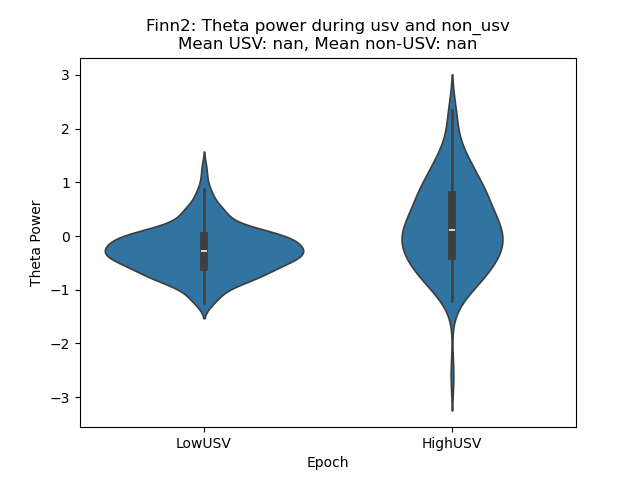

In [38]:
# Easily plot with seaborn
_, ax = plt.subplots()
title_text = f"Finn2: Theta power during usv and non_usv\nMean USV: {theta_power_usvs.mean():.4f}, Mean non-USV: {theta_power_non_usvs.mean():.4f}"
ax.set_title(title_text)
sns.violinplot(data=theta_power_df, x="Epoch", y="Theta Power")

## Read in movement/freezing data

In [39]:
import neuropy.io.dlcio as dlcio
dlc_path = '/data2/Trace_FC/Recording_Rats/Finn2/2023_05_08_training'
arena_side_pix = 60  # Keep this
arena_side_cm = 25.4  # Update this after measuring!!!
pix2cm = arena_side_cm / arena_side_pix

# Read in DLC data
sess.dlc = dlcio.DLC(dlc_path, pix2cm=pix2cm)

# Smooth position, get timestamps, and get speed
sess.dlc.get_timestamps('ms_webcam', include_str="2_training")
sess.dlc.smooth_pos(bodyparts=["crown_middle", "back_middle"])
sess.dlc.timestamps["Timestamps"] = sess.dlc.timestamps["Timestamps"].dt.tz_localize("America/Detroit")
sess.dlc.get_all_speed()

Using tracking file #1: /data2/Trace_FC/Recording_Rats/Finn2/2023_05_08_training/2_training/training/Finn2/gobears/2023_05_08/12_06_09/My_WebCam/Finn2_training_combined_movieDLC_resnet50_TraceFC_shockboxFeb28shuffle1_500000.h5


back_middle  crown_middle    left_ear  neck_base       nose  \
0              NaN           NaN  844.489094   0.637159  12.108097   
1              NaN           NaN    2.728748   6.160706   4.046535   
2              NaN           NaN    0.500291   2.127942   1.246952   
3              NaN           NaN    0.877834   2.103166   3.651505   
4              NaN           NaN    1.797900   6.230801   3.878855   
...            ...           ...         ...        ...        ...   
60617          NaN           NaN    2.342981   2.035985   3.616565   
60618          NaN           NaN    0.901130   3.763110   2.284191   
60619          NaN           NaN    2.506586   1.486250   2.946650   
60620          NaN           NaN    2.603536   2.204713   2.971853   
60621          NaN           NaN         NaN        NaN        NaN   

        right_ear  tail_base  tail_end  tail_middle  
0        3.873071   2.887589  1.702280     2.844129  
1      801.034192   1.108562  3.161103   856.491742  
2        0.620738   1.281399  0.614405     2.149913  
3        1.050498   1.206689  1.127960     1.574230  
4        1.498497   1.641239  5.458072     4.703678  
...           ...        ...       ...          ...  
60617    3.543801   2.648206  2.935423     0.528693  
60618    2.792867   3.369633  4.665316     0.266581  
60619    1.967454   0.868466  4.269405     1.141732  
60620    2.717636   0.843302  3.255342     0.808295  
60621         NaN        NaN       NaN          NaN  

[60622 rows x 9 columns]

In [40]:
t = Path("/data2/Trace_FC/Recording_Rats/Finn2/2023_05_08_training/2_training/training/Finn2/gobears/2023_05_08/12_06_09/My_WebCam/timeStamps.csv")
t.exists()

True

In [41]:
# Load in openephys times to sync
import neuropy.io.openephysio as oeio
sync_df = oeio.create_sync_df(sess.basepath)
sync_df["Total seconds from start"] = (sync_df["Datetime"] - sync_df["Datetime"][0]).dt.total_seconds()

# sync DLC times to your eeg file
sess.dlc.timestamps["Total seconds from OE start"] = (sess.dlc.timestamps["Timestamps"] - sync_df["Datetime"][0]).dt.total_seconds()
sess.dlc.timestamps["eeg_time"] = np.interp(sess.dlc.timestamps["Total seconds from OE start"], sync_df["Total seconds from start"], 
                                            sync_df["eeg_time"])
sess.dlc.timestamps

start time = 2023-05-08 11:54:10-04:00
start time = 2023-05-08 12:04:32-04:00
start time = 2023-05-08 12:41:12-04:00
start time = 2023-05-08 14:15:17-04:00
start time = 2023-05-08 15:12:40-04:00


Frame Number  Time Stamp (ms)  Buffer Index  \
0                 0              -29             0   
1                 1                2             0   
2                 2               34             0   
3                 3               70             0   
4                 4               98             0   
...             ...              ...           ...   
60617         60617          2026409             0   
60618         60618          2026450             0   
60619         60619          2026473             0   
60620         60620          2026521             0   
60621         60621          2026553             0   

                            Timestamps  Total seconds from OE start  \
0     2023-05-08 12:06:09.042000-04:00                      719.042   
1     2023-05-08 12:06:09.073000-04:00                      719.073   
2     2023-05-08 12:06:09.105000-04:00                      719.105   
3     2023-05-08 12:06:09.141000-04:00                      719.141   
4     2023-05-08 12:06:09.169000-04:00                      719.169   
...                                ...                          ...   
60617 2023-05-08 12:39:55.480000-04:00                     2745.480   
60618 2023-05-08 12:39:55.521000-04:00                     2745.521   
60619 2023-05-08 12:39:55.544000-04:00                     2745.544   
60620 2023-05-08 12:39:55.592000-04:00                     2745.592   
60621 2023-05-08 12:39:55.624000-04:00                     2745.624   

          eeg_time  
0       641.417941  
1       641.448941  
2       641.480941  
3       641.516941  
4       641.544941  
...            ...  
60617  2667.854707  
60618  2667.895707  
60619  2667.918707  
60620  2667.966707  
60621  2667.998707  

[60622 rows x 6 columns]

In [42]:
# Last calculate freezing times and plot again to check
frz_thresh = 0.25 # cm/sec  Adjust this to something that looks reasonable!
duration_thresh = 2 # sec, must be below the threshold above for at least that long to be considered freezing
bodypart_use = "crown_middle"
frz_bool = sess.dlc.speed[bodypart_use] < frz_thresh
frz_epochs = Epoch.from_boolean_array(frz_bool, t=sess.dlc.timestamps["eeg_time"])
frz_df = frz_epochs.to_dataframe()
frz_df = frz_df[frz_epochs.durations > duration_thresh]
frz_epochs = Epoch(frz_df)
frz_epochs

156 epochs
Snippet: 
          start         stop  duration label
0   839.399820   843.275818  3.875998  high
1   869.799802   871.871801  2.071999  high
2  1021.718709  1023.990708  2.271999  high
3  1050.486692  1053.464690  2.977998  high
4  1070.726679  1077.974675  7.247996  high

In [43]:
theta_power_frz = []
theta_power_sg = core.signal.Signal(theta_power, signal.sampling_rate)
for frz_epoch in frz_epochs:

    power_slice = theta_power_sg.time_slice(t_start=frz_epoch.starts, t_stop=frz_epoch.stops)
    theta_power_frz.append(power_slice.traces[0].mean())

theta_power_frz = np.array(theta_power_frz)

frz_df = pd.DataFrame({"Theta Power": theta_power_frz, "Epoch": "Freezing"})
theta_power_df = pd.concat((df1, df2, df3, df4, frz_df), axis=0).reset_index()

## moving speed during highusv/lowusv/frz

In [44]:
# moving speed during frz
mean_speeds_during_freezing = []
for start, end in zip(frz_epochs.starts, frz_epochs.stops):
    epoch_speeds = sess.dlc.speed[bodypart_use][(sess.dlc.timestamps["eeg_time"] >= start) & (sess.dlc.timestamps["eeg_time"] <= end)]
    mean_speed = epoch_speeds.mean()
    mean_speeds_during_freezing.append(mean_speed)

mean_speeds_during_freezing

[0.09092375888239358,
 0.12466390679324321,
 0.11873339096451212,
 0.10985662418429215,
 0.09130976761852938,
 0.09650251242918663,
 0.09387627050796583,
 0.08543130889659899,
 0.08897344486982214,
 0.09970192771049731,
 0.07672881458504309,
 0.103677800646679,
 0.08941023325727715,
 0.09102782101009414,
 0.07534173439976603,
 0.08615833385682453,
 0.07405915844814581,
 0.09025112114676445,
 0.11045011665618339,
 0.09509319074576435,
 0.10967486549118852,
 0.08479011623604722,
 0.111862943435057,
 0.10097213444061173,
 0.10872038041554705,
 0.1235861991838526,
 0.10681415011320657,
 0.11479949963637277,
 0.09227657701070253,
 0.11415535274546894,
 0.12290645040436181,
 0.08994056486303355,
 0.10243637979810248,
 0.08355120749708381,
 0.08671688087293847,
 0.09904870982511256,
 0.1197550838027718,
 0.12132549452241645,
 0.09471795814896199,
 0.1002217060204067,
 0.10440816283727815,
 0.10177970560874407,
 0.10064940421572578,
 0.10167251540975983,
 0.08081061618946589,
 0.08251378944343

In [45]:
# Moving speed during high USVs
mean_speeds_during_highusv = []
for start, end in zip(highusv_epochs['start'], highusv_epochs['stop']):
    epoch_speeds = sess.dlc.speed[bodypart_use][(sess.dlc.timestamps["eeg_time"] >= start) & (sess.dlc.timestamps["eeg_time"] <= end)]
    mean_speed = epoch_speeds.mean()
    mean_speeds_during_highusv.append(mean_speed)

mean_speeds_during_highusv


[23.506480123523126,
 14.154870189621521,
 7.108234105270276,
 7.2884329163702954,
 7.506602992117822,
 27.45685573193675,
 5.044874504900472,
 25.406445102906662,
 3.055372434069071,
 0.768726922020508,
 0.39679938931436465,
 10.68946361519456,
 2.176568543684551,
 0.5161546277321482,
 3.2584966449833086,
 1.0331793098390665,
 1.483230690143949,
 7.922369353677308,
 16.068817638531364,
 5.51812065635804,
 10.161464218323363,
 4.994844201977825,
 9.428301866023896,
 10.496851806456561,
 10.051831746133171,
 5.779332418557759,
 15.061902529784614,
 6.358719115889778,
 0.6367610611862576,
 4.873627419602324,
 3.244811897034367,
 2.1638178655371525,
 13.3170583852046,
 nan,
 11.999573981242584,
 0.28026143440603346,
 0.8691301386335124,
 1.1304370188917856,
 6.249406311935421,
 1.8586046132443312,
 0.819986023106077,
 0.2835870299221603,
 7.2433227869562415,
 32.17520750672162,
 15.182767147502092,
 27.932177326681234,
 26.14061646058414,
 21.013491680653367,
 17.02309066853943,
 1.569626

In [46]:
# Moving speed during low USVs
mean_speeds_during_lowusv = []
for start, end in zip(lowusv_epochs['start'], lowusv_epochs['stop']):
    epoch_speeds = sess.dlc.speed[bodypart_use][(sess.dlc.timestamps["eeg_time"] >= start) & (sess.dlc.timestamps["eeg_time"] <= end)]
    mean_speed = epoch_speeds.mean()
    mean_speeds_during_lowusv.append(mean_speed)

# Output the results
mean_speeds_during_lowusv

[4.012638271557073,
 0.2702813663875541,
 2.1097895241811266,
 1.9725351263264022,
 0.23904166836451374,
 6.521660482201924,
 1.485740837335953,
 0.2174789341297234,
 0.08296873332362274,
 0.08385053734970817,
 1.6305496537272486,
 0.1347510806600814,
 0.05950434868136945,
 0.07494090457205071,
 0.06202362684547991,
 0.09702137665437376,
 0.08410922564623045,
 0.09595707509884291,
 0.13951548610481548,
 0.13747095946297766,
 3.9676010424210277,
 0.6613450363412207,
 0.4119519971051031,
 0.27868471264622485,
 3.712285866031518,
 1.325392951204432,
 2.029762584285121,
 5.252636008423889,
 0.9609741914023163,
 0.5092982257696143,
 0.20841581419049282,
 0.2050532818711502,
 0.3936321227081467,
 0.27476120682056737,
 6.755965710184557,
 2.8452740263550274,
 0.18842781971872494,
 0.19821899169904067,
 0.12525683099159562,
 0.10790165279917839,
 0.14754398483017614,
 2.1180400699768582,
 0.31863998496382084,
 0.15097686206815766,
 0.2863661526991847,
 0.12365773104777138,
 0.19424642257370062

## Violinplot theta power during USV/lowUSV/highUSV/frz

Theta Power    Epoch
0       -0.356083      USV
1       -0.765086      USV
2       -0.150880      USV
3       -0.531718      USV
4        0.195621      USV
...           ...      ...
1053    -0.591899  non-USV
1054    -1.883046  non-USV
1055     0.316815  non-USV
1056     0.543478  non-USV
1057    -0.141129  non-USV

[1058 rows x 2 columns]

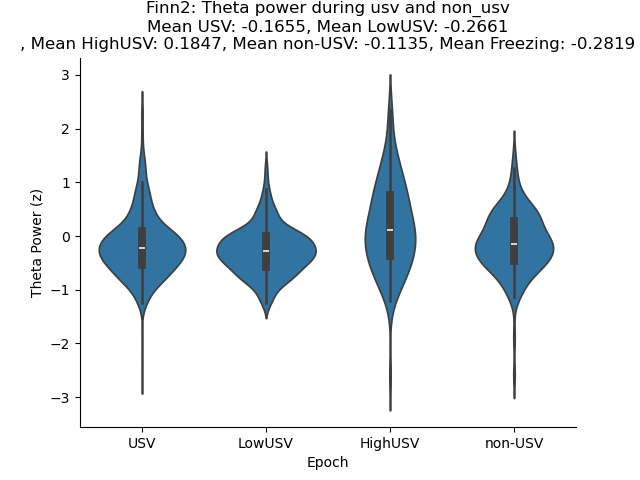

In [79]:
# Easily plot with seaborn
vio1, ax = plt.subplots()

title_text = f"Finn2: Theta power during usv and non_usv\nMean USV: {theta_power_usvs.mean():.4f}, Mean LowUSV: {theta_power_lowusvs.mean():.4f}\n, Mean HighUSV: {theta_power_highusvs.mean():.4f}, Mean non-USV: {theta_power_non_usvs.mean():.4f}, Mean Freezing: {theta_power_frz.mean():.4f}"
ax.set_title(title_text)
sns.violinplot(data=theta_power_df, x="Epoch", y="Theta Power")
ax.set_ylabel("Theta Power (z)")
sns.despine(ax=ax)


vio1.savefig('/home/bowenw/Documents/thesisplots/Finn2 usv nonusv thetapower violinplot low high.png')

import pingouin as pg
pg.pairwise_tests(data=theta_power_df, dv="Theta Power", between="Epoch", padjust="bonf")

# Try High/low USV

recording_duration = 3000 
theta_power_usvs = []
theta_power_non_usvs = []
theta_power_highusvs = [] 
theta_power_lowusvs = []

for i, usv_epoch in enumerate(usv_epochs):
    if usv_epoch.stops > recording_duration:

        usv_epoch.stops = recording_duration
    

    power_slice = theta_power_sg.time_slice(t_start=usv_epoch.starts, t_stop=min(usv_epoch.stops, recording_duration))
    theta_power_usvs.append(power_slice.traces[0].mean())


    next_start = usv_epochs[i+1].starts if i+1 < len(usv_epochs) else recording_duration

    if usv_epoch.stops < next_start and (next_start - usv_epoch.stops) > 1:
        power_slice = theta_power_sg.time_slice(t_start=usv_epoch.stops, t_stop=next_start)
        theta_power_non_usvs.append(power_slice.traces[0].mean())

    if usv_epoch.to_dataframe()['Freq_Min'].values[0] > 23:

        power_slice = theta_power_sg.time_slice(t_start=usv_epoch.starts[0], t_stop=min(usv_epoch.stops[0], recording_duration))
        theta_power_highusvs.append(power_slice.traces[0].mean())
        
    if usv_epoch.to_dataframe()['Freq_Min'].values[0] < 23:

        power_slice = theta_power_sg.time_slice(t_start=usv_epoch.starts[0], t_stop=min(usv_epoch.stops[0], recording_duration))
        theta_power_lowusvs.append(power_slice.traces[0].mean())
         
theta_power_lowusvs= np.array(theta_power_lowusvs)
theta_power_highusvs = np.array(theta_power_highusvs)
theta_power_usvs = np.array(theta_power_usvs)
theta_power_non_usvs = np.array(theta_power_non_usvs)


df1 = pd.DataFrame({"Theta Power": theta_power_usvs, "Epoch": "USV"})
df2 = pd.DataFrame({"Theta Power": theta_power_lowusvs, "Epoch": "LowUSV"})
df3 = pd.DataFrame({"Theta Power": theta_power_highusvs, "Epoch": "HighUSV"})
df4 = pd.DataFrame({"Theta Power": theta_power_non_usvs, "Epoch": "non-USV"})
theta_power_df = pd.concat([df1, df2, df3, df4], axis=0).reset_index(drop=True)

theta_power_df

# # Easily plot with seaborn
# _, ax = plt.subplots()
# title_text = f"Finn2: Theta power during usv and non_usv\nMean USV: {theta_power_usvs.mean():.4f}, Mean LowUSV: {theta_power_lowusvs.mean():.4f}\n, Mean HighUSV: {theta_power_highusvs.mean():.4f}, Mean non-USV: {theta_power_non_usvs.mean():.4f}"
# ax.set_title(title_text)
# sns.violinplot(data=theta_power_df, x="Epoch", y="Theta Power")

In [48]:
theta_power_usvs

array([-3.56082980e-01, -7.65086059e-01, -1.50879560e-01, -5.31718088e-01,
        1.95620648e-01, -6.39049809e-01,  8.53976081e-01, -1.78163588e-01,
       -1.21897112e-01,  8.31518297e-01,  7.71673624e-01, -1.95562724e-01,
        1.32285797e+00,  6.91073189e-01,  1.81571356e-01, -3.87846020e-01,
        6.18760821e-01,  7.13885099e-02,  1.84687027e-01,  3.44195799e-01,
        2.35357421e+00,  3.14174093e-01,  9.79253017e-01,  4.78348827e-01,
        1.86152490e+00,  1.16203403e+00,  8.34711547e-01,  2.29204112e+00,
        7.12039462e-01,  5.07339488e-01,  1.03916566e+00,  1.16437475e-01,
        1.58173664e+00,  1.07308408e-01,  1.97214686e+00,  1.42406704e+00,
        8.42284760e-01, -9.12808188e-01, -4.06082159e-02, -1.03893949e-01,
        1.17964128e+00,  3.71529395e-01,  1.33729061e+00, -2.58998706e+00,
        1.52884911e+00,  8.65655445e-02, -4.92536215e-01,  3.93912670e-01,
       -5.27672041e-01, -4.56881582e-01,  1.11703588e-01, -6.21477390e-01,
       -3.05666563e-01,  

In [49]:
theta_power_non_usvs

array([-0.49480607,  0.20813953, -0.19209213,  0.11174097, -0.08850525,
        1.22356327,  0.42179743, -0.14807222,  0.47019686,  1.53567488,
        0.25332167,  1.08014637,  0.51028364,  0.92503822,  1.27230801,
        0.49198105,  0.72595973,  0.27189012,  0.42560902,  0.26334778,
        0.54677833,  0.17158427,  0.47011421,  0.35146587, -0.36075663,
       -0.38904975,  0.03656414,  0.42281379, -0.55892659,  0.63348688,
        0.08806791, -0.31618196, -0.13956001,  0.46821695,  0.82069319,
       -0.13987009, -0.04903751, -0.05253265, -0.41139968,  0.28221706,
        0.44265024,  0.12598814, -0.50946833, -0.29738317, -0.20690332,
       -0.4701031 , -0.29642692,  0.35127133, -0.27203077, -0.43812474,
       -0.58859878,  0.03127882, -0.43086917, -2.58998706,  0.36064013,
        0.77955355, -0.06234573,  0.37194735,  0.66662452, -0.05567909,
        0.62718864, -0.70225596, -0.44196158, -1.06373803, -0.75381264,
       -0.66546963, -0.35391511, -0.81528486, -1.13203238, -0.95

In [50]:
theta_power_frz

array([-5.86790055e-01, -1.47517998e-01,  5.21595391e-01, -3.69961788e-01,
       -9.02508803e-02, -3.25605581e-01, -1.63455784e-01, -1.16885259e-01,
       -4.33819671e-01, -4.69344703e-01, -4.13285035e-01, -7.09473227e-01,
       -2.13127734e-01, -2.46419358e-01, -4.22884144e-01,  6.66394211e-02,
       -3.76232666e-01, -4.79447775e-01, -7.06169544e-01, -5.87203007e-01,
       -5.38464881e-01, -4.07606000e-01, -6.73249446e-01, -1.32616846e-01,
       -6.12113142e-01, -1.99192278e-01, -6.39951562e-01, -8.82165612e-01,
       -7.29828640e-01, -9.32040371e-01, -5.21215577e-01, -5.34237712e-01,
       -6.84594915e-01, -3.54404465e-01, -3.47276420e-04, -6.75891744e-01,
       -6.21859451e-02, -4.27950700e-01, -4.30142672e-01, -2.76114409e-01,
       -1.27623267e-02, -3.26424563e-01, -2.88723775e-01,  2.70655575e-01,
       -1.21395759e-01, -3.02529293e-01, -5.27090973e-01, -2.73741148e-01,
       -3.06166752e-01, -5.71334907e-01,  4.03864569e-01, -6.79628996e-01,
       -2.50591332e-01, -

## lowUSV/highUSV violin plot

In [51]:
recording_duration = 3000 
theta_power_usvs = []
theta_power_non_usvs = []
theta_power_highusvs = [] 
theta_power_lowusvs = []

for i, usv_epoch in enumerate(usv_epochs):
    if usv_epoch.stops > recording_duration:

        usv_epoch.stops = recording_duration
    

    if usv_epoch.to_dataframe()['Freq_Min'].values[0] > 23:

        power_slice = theta_power_sg.time_slice(t_start=usv_epoch.starts[0], t_stop=min(usv_epoch.stops[0], recording_duration))
        theta_power_highusvs.append(power_slice.traces[0].mean())
        
    if usv_epoch.to_dataframe()['Freq_Min'].values[0] < 23:

        power_slice = theta_power_sg.time_slice(t_start=usv_epoch.starts[0], t_stop=min(usv_epoch.stops[0], recording_duration))
        theta_power_lowusvs.append(power_slice.traces[0].mean())
         
theta_power_lowusvs= np.array(theta_power_lowusvs)
theta_power_highusvs = np.array(theta_power_highusvs)
theta_power_usvs = np.array(theta_power_usvs)
theta_power_non_usvs = np.array(theta_power_non_usvs)


df1 = pd.DataFrame({"Theta Power": theta_power_usvs, "Epoch": "USV"})
df2 = pd.DataFrame({"Theta Power": theta_power_lowusvs, "Epoch": "LowUSV"})
df3 = pd.DataFrame({"Theta Power": theta_power_highusvs, "Epoch": "HighUSV"})
df4 = pd.DataFrame({"Theta Power": theta_power_non_usvs, "Epoch": "non-USV"})
theta_power_df = pd.concat([df2, df3], axis=0).reset_index(drop=True)

theta_power_df

Theta Power    Epoch
0      -0.902422   LowUSV
1      -1.249937   LowUSV
2       0.007092   LowUSV
3      -0.282130   LowUSV
4      -0.485489   LowUSV
..           ...      ...
452    -0.278465  HighUSV
453     1.037206  HighUSV
454     1.394132  HighUSV
455     0.804420  HighUSV
456     1.178230  HighUSV

[457 rows x 2 columns]

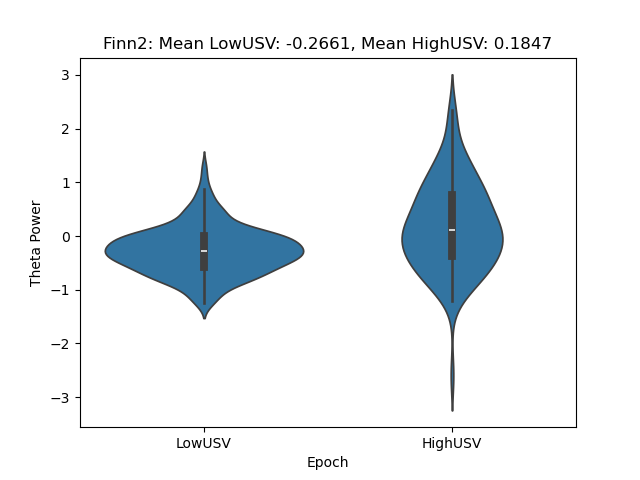

In [52]:
# Easily plot with seaborn
vio4, ax = plt.subplots()
title_text = f"{animal}: Mean LowUSV: {theta_power_lowusvs.mean():.4f}, Mean HighUSV: {theta_power_highusvs.mean():.4f}"
ax.set_title(title_text)
sns.violinplot(data=theta_power_df, x="Epoch", y="Theta Power")
vio4.savefig('/home/bowenw/Documents/thesisplots/Finn2 usv nonusv thetapower violinplot low high ONLY.png')

## Theta power during USV/freezing/USV during freezing/USV during non-frz

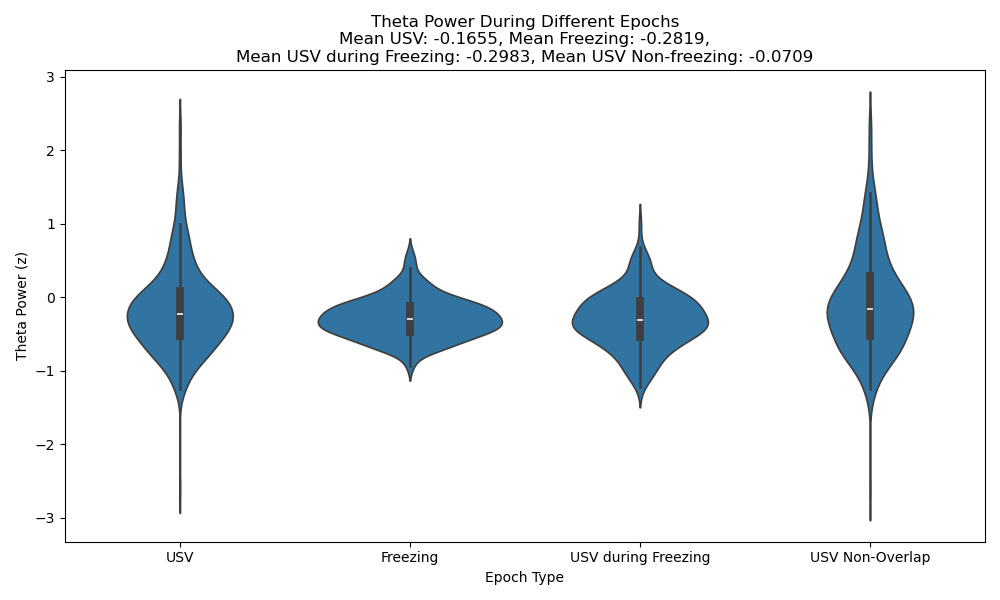

In [53]:
def categorize_usvs(usv_df, frz_df):
    usvs_during_freezing = []
    usvs_non_overlap = []
    for index, usv in usv_df.iterrows():
        overlap = False
        for _, frz in frz_df.iterrows():
            if (usv['start'] < frz['stop']) and (usv['stop'] > frz['start']):
                overlap = True
                usvs_during_freezing.append(usv)
                break
        if not overlap:
            usvs_non_overlap.append(usv)
    return pd.DataFrame(usvs_during_freezing), pd.DataFrame(usvs_non_overlap)

# Calculate the mean theta power for a given epoch type
def calculate_theta_power(signal, epochs_df):
    theta_power_values = []
    for _, epoch in epochs_df.iterrows():
        power_slice = signal.time_slice(t_start=epoch['start'], t_stop=epoch['stop'])
        theta_power_values.append(power_slice.traces[0].mean())
    return np.array(theta_power_values)

# Convert Epoch objects to DataFrames
usv_df = usv_epochs.to_dataframe()
frz_df = frz_epochs.to_dataframe()

# Categorize USVs
usv_during_freezing_df, usv_non_overlap_df = categorize_usvs(usv_df, frz_df)

# Assuming theta_power_sg is already correctly instantiated:
# Calculate theta power for each epoch type
theta_power_usv = calculate_theta_power(theta_power_sg, usv_df)
theta_power_frz = calculate_theta_power(theta_power_sg, frz_df)
theta_power_usv_during_freezing = calculate_theta_power(theta_power_sg, usv_during_freezing_df)
theta_power_usv_non_overlap = calculate_theta_power(theta_power_sg, usv_non_overlap_df)

# Create DataFrame for plotting
df_usv = pd.DataFrame({"Theta Power": theta_power_usv, "Epoch": "USV"})
df_frz = pd.DataFrame({"Theta Power": theta_power_frz, "Epoch": "Freezing"})
df_usv_during_freezing = pd.DataFrame({"Theta Power": theta_power_usv_during_freezing, "Epoch": "USV during Freezing"})
df_usv_non_overlap = pd.DataFrame({"Theta Power": theta_power_usv_non_overlap, "Epoch": "USV Non-Overlap"})

theta_power_df = pd.concat([df_usv, df_frz, df_usv_during_freezing, df_usv_non_overlap]).reset_index(drop=True)

mean_theta_power_usv = theta_power_usv.mean()
mean_theta_power_frz = theta_power_frz.mean()
mean_theta_power_usv_during_freezing = theta_power_usv_during_freezing.mean()
mean_theta_power_usv_non_freezing = theta_power_usv_non_overlap.mean()



title_text = (
    f"Theta Power During Different Epochs\n"
    f"Mean USV: {mean_theta_power_usv:.4f}, "
    f"Mean Freezing: {mean_theta_power_frz:.4f},\n"
    f"Mean USV during Freezing: {mean_theta_power_usv_during_freezing:.4f}, "
    f"Mean USV Non-freezing: {mean_theta_power_usv_non_freezing:.4f}"
)

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.violinplot(data=theta_power_df, x="Epoch", y="Theta Power")
plt.title(title_text)
plt.xlabel("Epoch Type")
plt.ylabel("Theta Power (z)")
plt.tight_layout()
plt.show()

In [54]:
df_usv_during_freezing

Theta Power                Epoch
0       0.996799  USV during Freezing
1       0.215689  USV during Freezing
2      -0.942623  USV during Freezing
3      -0.470623  USV during Freezing
4      -0.085839  USV during Freezing
..           ...                  ...
185     0.519156  USV during Freezing
186    -0.610791  USV during Freezing
187    -0.870880  USV during Freezing
188    -0.139522  USV during Freezing
189    -0.207131  USV during Freezing

[190 rows x 2 columns]

# SWR power

In [55]:
from neuropy.analyses.oscillations import detect_ripple_epochs
ripple_channel = 7
thresh = (2, None)  # conservative but good
edge_cutoff = 0.5
exclude_theta_epochs = False  # make this true if you end up with a lot of false positive ripples as gamma events during theta

if not exclude_theta_epochs:
    ripple_epochs, ripple_power = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                         edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
else:
    ripple_epochs, ripple_power = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                         edge_cutoff=edge_cutoff,
                                         ignore_epochs=art_epochs.__add__(theta_epochs), return_power=True)
sess.recinfo.write_epochs(ripple_epochs, ext='swr')
ripple_epochs_file = sess.filePrefix.with_suffix(".ripple_epochs.npy")
ripple_epochs.save(ripple_epochs_file)

Selected channels for ripples: [7]
15273 epochs remaining with durations within (0.05,0.45)
/data3/Trace_FC/Recording_Rats/Finn2/2023_05_08_training/Finn2_training_denoised.ripple_epochs.npy saved


In [56]:
ripple_power_sg = core.signal.Signal(ripple_power, signal.sampling_rate)

In [57]:
recording_duration = 3000 
ripple_power_usvs = []
ripple_power_non_usvs = []

for i, usv_epoch in enumerate(usv_epochs):
    if usv_epoch.stops > recording_duration:
        usv_epoch.stops = recording_duration
    
    power_slice = ripple_power_sg.time_slice(t_start=usv_epoch.starts, t_stop=min(usv_epoch.stops, recording_duration))
    ripple_power_usvs.append(power_slice.traces[0].mean())

    next_start = usv_epochs[i+1].starts if i+1 < len(usv_epochs) else recording_duration

    if usv_epoch.stops < next_start and (next_start - usv_epoch.stops) > 1:
        power_slice = ripple_power_sg.time_slice(t_start=usv_epoch.stops, t_stop=next_start)
        ripple_power_non_usvs.append(power_slice.traces[0].mean())


ripple_power_usvs = np.array(ripple_power_usvs)
ripple_power_non_usvs = [x for x in ripple_power_non_usvs if not np.isnan(x)]
ripple_power_non_usvs = np.array(ripple_power_non_usvs)


df1 = pd.DataFrame({"ripple Power": ripple_power_usvs, "Epoch": "USV"})
df2 = pd.DataFrame({"ripple Power": ripple_power_non_usvs, "Epoch": "non-USV"})
ripple_power_df = pd.concat([df1, df2], axis=0).reset_index(drop=True)

ripple_power_df

ripple Power    Epoch
0        0.627443      USV
1        0.503293      USV
2        1.261088      USV
3        0.274299      USV
4        1.269126      USV
..            ...      ...
596     -0.151126  non-USV
597     -1.549578  non-USV
598      1.962959  non-USV
599      0.372824  non-USV
600     -0.010653  non-USV

[601 rows x 2 columns]

<Axes: title={'center': 'Finn2: ripple power during usv and non_usv\nMean USV: -0.0870, Mean non-USV: -0.1289'}, xlabel='Epoch', ylabel='ripple Power'>

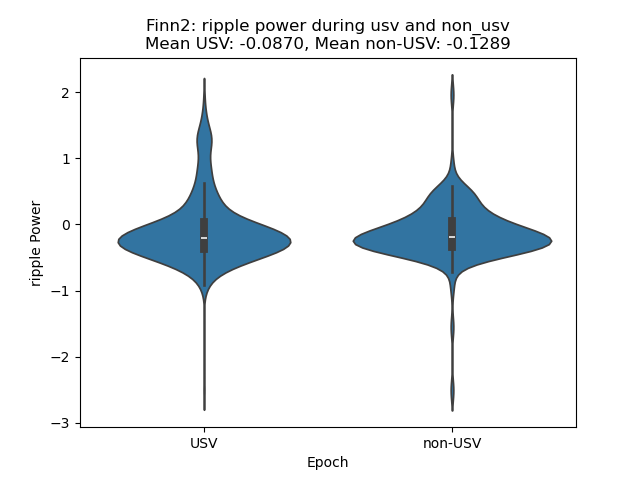

In [58]:
# Easily plot with seaborn
_, ax = plt.subplots()
title_text = f"Finn2: ripple power during usv and non_usv\nMean USV: {ripple_power_usvs.mean():.4f}, Mean non-USV: {ripple_power_non_usvs.mean():.4f}"
ax.set_title(title_text)
sns.violinplot(data=ripple_power_df, x="Epoch", y="ripple Power")

## ripple power during USV/nonUSV/Freezing

In [59]:
ripple_power_frz = []
ripple_power_sg = core.signal.Signal(ripple_power, signal.sampling_rate)
for frz_epoch in frz_epochs:

    power_slice = ripple_power_sg.time_slice(t_start=frz_epoch.starts, t_stop=frz_epoch.stops)
    ripple_power_frz.append(power_slice.traces[0].mean())

ripple_power_frz = np.array(ripple_power_frz)

frz_df = pd.DataFrame({"ripple Power": ripple_power_frz, "Epoch": "Freezing"})
ripple_power_df = pd.concat((df1, df2, frz_df), axis=0).reset_index()

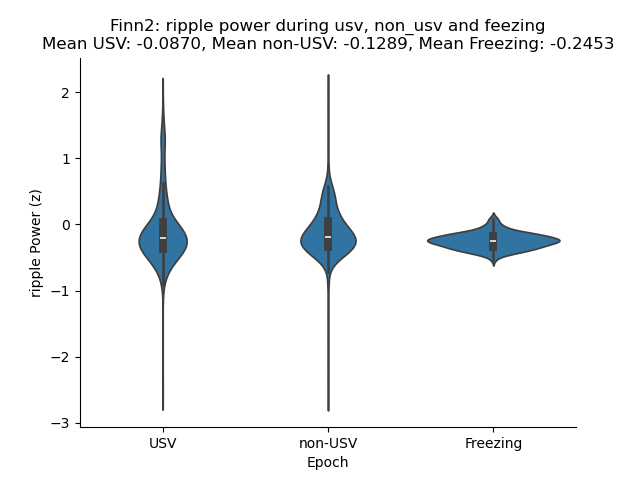

In [60]:
# Easily plot with seaborn
viof, ax = plt.subplots()

title_text = f"Finn2: ripple power during usv, non_usv and feezing\nMean USV: {ripple_power_usvs.mean():.4f}, Mean non-USV: {ripple_power_non_usvs.mean():.4f}, Mean Freezing: {ripple_power_frz.mean():.4f}"
ax.set_title(title_text)
sns.violinplot(data=ripple_power_df, x="Epoch", y="ripple Power")
ax.set_ylabel("ripple Power (z)")
sns.despine(ax=ax)
viof.savefig('/home/bowenw/Documents/thesisplots/Finn2 usv nonusv ripplepower violinplot.png')

In [61]:
import pingouin as pg
pg.pairwise_tests(data=ripple_power_df, dv="ripple Power", between="Epoch", padjust="bonf")

Contrast         A        B  Paired  Parametric         T         dof  \
0    Epoch  Freezing      USV   False        True -6.221934  572.165654   
1    Epoch  Freezing  non-USV   False        True -3.249542  164.765764   
2    Epoch       USV  non-USV   False        True  1.004163  288.162912   

  alternative         p-unc        p-corr p-adjust       BF10    hedges  
0   two-sided  9.492249e-10  2.847675e-09     bonf  9.217e+06 -0.359526  
1   two-sided  1.401291e-03  4.203873e-03     bonf     18.474 -0.387543  
2   two-sided  3.161426e-01  9.484278e-01     bonf      0.173  0.086562

In [62]:
ripple_power_usvs

array([ 6.27443425e-01,  5.03292502e-01,  1.26108818e+00,  2.74298503e-01,
        1.26912627e+00, -4.23384724e-01,  1.26880087e+00, -6.58385715e-03,
        1.48681073e-02,  5.22770970e-01,  9.52973454e-02,  1.04165384e+00,
       -5.35854996e-01,  4.94311643e-01, -3.08695020e-01, -6.01232610e-01,
        8.92284360e-01,  1.66511989e+00,  1.66529598e+00,  1.18482968e+00,
        3.78862269e-01,  1.31819626e-01,  1.25160233e+00, -3.59081276e-02,
       -1.58187615e-01, -1.37617053e-01,  6.19763529e-01,  8.67371829e-02,
       -8.29006447e-02,  2.30520584e-01,  2.69957044e-01,  2.64858131e-01,
       -2.48430633e-01,  1.43500986e+00,  8.64006248e-01, -4.33497609e-01,
       -8.00915420e-01,  1.08025627e-01, -1.53917169e-01,  3.84746409e-01,
       -7.14185600e-01, -2.43891010e-01, -1.26235134e-01, -2.50481116e+00,
        1.20851338e+00,  1.05414775e-01,  1.53470340e+00, -2.14308823e-01,
       -3.24204598e-01,  8.63496134e-03,  5.77602116e-01,  4.81406882e-01,
       -3.75901840e-01,  

In [63]:
ripple_power_non_usvs

array([ 1.75791946e-01,  4.65477135e-01,  4.34417218e-01,  1.63910888e-01,
        2.64613211e-01,  3.75085084e-01,  3.18888862e-01,  9.04715825e-02,
        4.85008486e-01,  5.11930351e-01,  5.27697074e-01,  2.54266079e-01,
        1.66787924e-01,  6.07106264e-02,  5.60752006e-02,  1.10108981e-01,
        1.04613782e-03,  3.79961164e-01,  3.18148990e-01, -4.70654071e-02,
       -1.22073903e-01, -1.02289301e-01, -1.78501003e-01, -4.92300498e-02,
       -1.62334628e-01, -3.28021907e-01, -2.03912520e-01, -2.11936298e-01,
       -4.41258580e-01, -1.22580392e-01, -2.55016983e-01, -2.46599647e-01,
        2.92692518e-02,  7.60767476e-02, -1.99231142e-01, -9.26236042e-02,
       -2.32378815e-01, -2.44131622e-01, -2.05599990e-01, -8.11810429e-02,
       -6.39031087e-02, -1.10594103e-01,  1.71602261e-01, -2.13622761e-01,
       -2.40297788e-01, -3.99743312e-01, -2.16512547e-01, -3.21945701e-01,
       -2.38278317e-01, -2.95142192e-01, -3.10371636e-01, -2.31035377e-01,
       -3.14939598e-01, -

In [64]:
ripple_power_frz

array([-0.18991577,  0.01215131, -0.11491194, -0.21935017, -0.39122573,
       -0.42592633, -0.26719936, -0.24499814, -0.3143897 ,  0.07773572,
       -0.24025261, -0.38586974, -0.31328429, -0.11906895, -0.28919763,
       -0.2729441 , -0.36648089, -0.26673325, -0.39525517, -0.45906946,
        0.07653767, -0.22294381, -0.175128  , -0.19687006, -0.1920397 ,
       -0.40769461, -0.13960167, -0.25185352, -0.07958924, -0.39871856,
       -0.43630873, -0.30031084, -0.34361834, -0.19543718, -0.12370794,
       -0.04098392, -0.35704134, -0.29417409, -0.33237123, -0.30017374,
       -0.20855511, -0.34040318, -0.20022413, -0.24774164, -0.27531989,
       -0.30268299, -0.26184762, -0.30322659, -0.35014603, -0.43002189,
       -0.1414928 , -0.21517336, -0.26696529, -0.2497201 , -0.34788919,
       -0.21621048, -0.17409541, -0.44140221, -0.53303037, -0.29849018,
       -0.1454302 , -0.15715763, -0.14549888, -0.17472024, -0.21666984,
       -0.20314183, -0.23179327, -0.30730795, -0.38321796, -0.22

## ripple power during lowUSV/highUSV

In [65]:
recording_duration = 3000 

ripple_power_highusvs = [] 
ripple_power_lowusvs = []

for i, usv_epoch in enumerate(usv_epochs):
    if usv_epoch.stops > recording_duration:

        usv_epoch.stops = recording_duration
    

    if usv_epoch.to_dataframe()['Freq_Min'].values[0] > 23:

        power_slice = ripple_power_sg.time_slice(t_start=usv_epoch.starts[0], t_stop=min(usv_epoch.stops[0], recording_duration))
        ripple_power_highusvs.append(power_slice.traces[0].mean())
        
    if usv_epoch.to_dataframe()['Freq_Min'].values[0] < 23:

        power_slice = ripple_power_sg.time_slice(t_start=usv_epoch.starts[0], t_stop=min(usv_epoch.stops[0], recording_duration))
        ripple_power_lowusvs.append(power_slice.traces[0].mean())
         
ripple_power_lowusvs= np.array(ripple_power_lowusvs)
ripple_power_highusvs = np.array(ripple_power_highusvs)


df2 = pd.DataFrame({"ripple Power": ripple_power_lowusvs, "Epoch": "LowUSV"})
df3 = pd.DataFrame({"ripple Power": ripple_power_highusvs, "Epoch": "HighUSV"})
ripple_power_df = pd.concat([df2, df3], axis=0).reset_index(drop=True)

ripple_power_df

ripple Power    Epoch
0       -0.249741   LowUSV
1       -0.121902   LowUSV
2        0.302283   LowUSV
3        0.146225   LowUSV
4       -0.327010   LowUSV
..            ...      ...
452     -0.535640  HighUSV
453     -0.305680  HighUSV
454     -0.461593  HighUSV
455     -0.181654  HighUSV
456     -0.343260  HighUSV

[457 rows x 2 columns]

/tmp/ipykernel_1389730/3091503991.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  vio3, ax = plt.subplots()


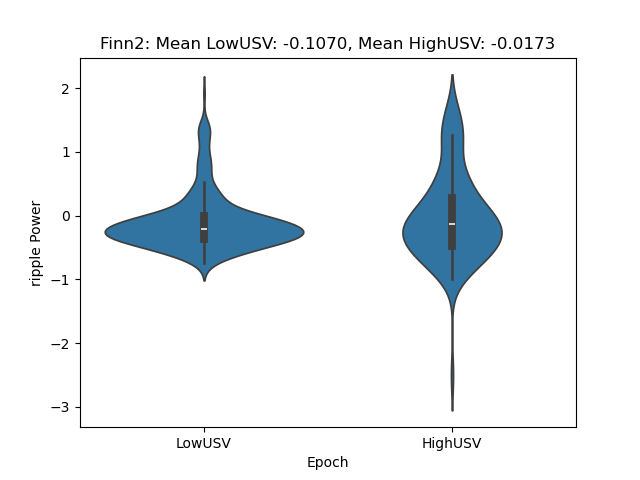

In [66]:
# Easily plot with seaborn
vio3, ax = plt.subplots()
title_text = f"{animal}: Mean LowUSV: {ripple_power_lowusvs.mean():.4f}, Mean HighUSV: {ripple_power_highusvs.mean():.4f}"
ax.set_title(title_text)
sns.violinplot(data=ripple_power_df, x="Epoch", y="ripple Power")
vio3.savefig('/home/bowenw/Documents/thesisplots/Finn2 usv nonusv ripplepower violinplot low high ONLY.png')

In [67]:
import pingouin as pg
pg.pairwise_tests(data=ripple_power_df, dv="ripple Power", between="Epoch", padjust="bonf")

Contrast        A       B  Paired  Parametric        T         dof  \
0    Epoch  HighUSV  LowUSV   False        True  1.23683  124.437217   

  alternative     p-unc   BF10    hedges  
0   two-sided  0.218479  0.257  0.177908

<Axes: xlabel='Epoch', ylabel='ripple Power'>

/home/bowenw/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/seaborn/categorical.py:3370: UserWarning: 22.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


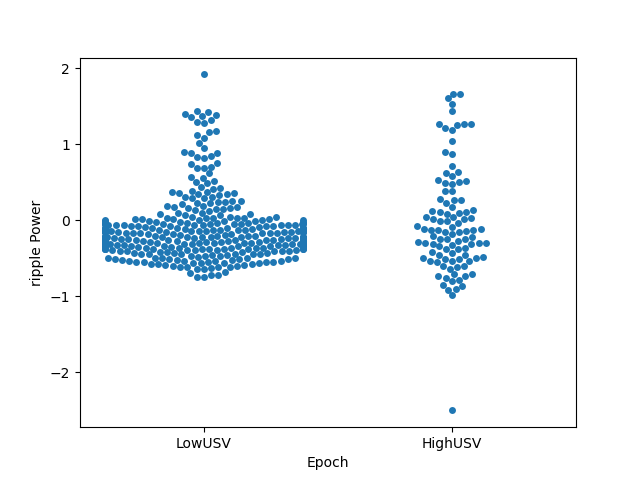

In [68]:
_, ax = plt.subplots()
sns.swarmplot(data=ripple_power_df, x="Epoch", y="ripple Power", ax=ax)

## ripple power during USV/frz/USV during frz/USV during nonfrz

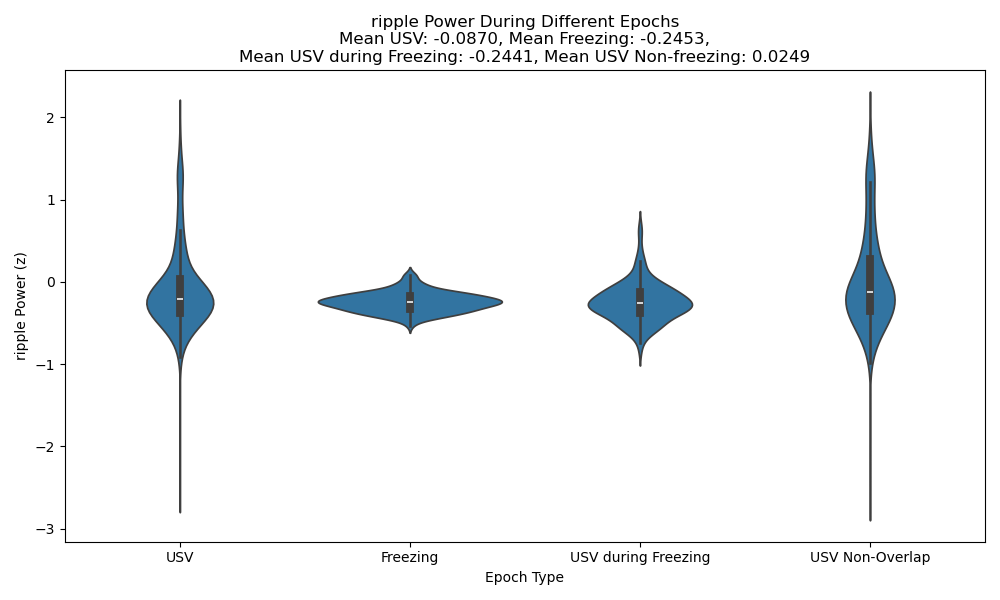

In [69]:
def categorize_usvs(usv_df, frz_df):
    usvs_during_freezing = []
    usvs_non_overlap = []
    for index, usv in usv_df.iterrows():
        overlap = False
        for _, frz in frz_df.iterrows():
            if (usv['start'] < frz['stop']) and (usv['stop'] > frz['start']):
                overlap = True
                usvs_during_freezing.append(usv)
                break
        if not overlap:
            usvs_non_overlap.append(usv)
    return pd.DataFrame(usvs_during_freezing), pd.DataFrame(usvs_non_overlap)

# Calculate the mean ripple power for a given epoch type
def calculate_ripple_power(signal, epochs_df):
    ripple_power_values = []
    for _, epoch in epochs_df.iterrows():
        power_slice = signal.time_slice(t_start=epoch['start'], t_stop=epoch['stop'])
        ripple_power_values.append(power_slice.traces[0].mean())
    return np.array(ripple_power_values)

# Convert Epoch objects to DataFrames
usv_df = usv_epochs.to_dataframe()
frz_df = frz_epochs.to_dataframe()

# Categorize USVs
usv_during_freezing_df, usv_non_overlap_df = categorize_usvs(usv_df, frz_df)

# Assuming ripple_power_sg is already correctly instantiated:
# Calculate ripple power for each epoch type
ripple_power_usv = calculate_ripple_power(ripple_power_sg, usv_df)
ripple_power_frz = calculate_ripple_power(ripple_power_sg, frz_df)
ripple_power_usv_during_freezing = calculate_ripple_power(ripple_power_sg, usv_during_freezing_df)
ripple_power_usv_non_overlap = calculate_ripple_power(ripple_power_sg, usv_non_overlap_df)

# Create DataFrame for plotting
df_usv = pd.DataFrame({"ripple Power": ripple_power_usv, "Epoch": "USV"})
df_frz = pd.DataFrame({"ripple Power": ripple_power_frz, "Epoch": "Freezing"})
df_usv_during_freezing = pd.DataFrame({"ripple Power": ripple_power_usv_during_freezing, "Epoch": "USV during Freezing"})
df_usv_non_overlap = pd.DataFrame({"ripple Power": ripple_power_usv_non_overlap, "Epoch": "USV Non-Overlap"})

ripple_power_df = pd.concat([df_usv, df_frz, df_usv_during_freezing, df_usv_non_overlap]).reset_index(drop=True)

mean_ripple_power_usv = ripple_power_usv.mean()
mean_ripple_power_frz = ripple_power_frz.mean()
mean_ripple_power_usv_during_freezing = ripple_power_usv_during_freezing.mean()
mean_ripple_power_usv_non_freezing = ripple_power_usv_non_overlap.mean()



title_text = (
    f"ripple Power During Different Epochs\n"
    f"Mean USV: {mean_ripple_power_usv:.4f}, "
    f"Mean Freezing: {mean_ripple_power_frz:.4f},\n"
    f"Mean USV during Freezing: {mean_ripple_power_usv_during_freezing:.4f}, "
    f"Mean USV Non-freezing: {mean_ripple_power_usv_non_freezing:.4f}"
)

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.violinplot(data=ripple_power_df, x="Epoch", y="ripple Power")
plt.title(title_text)
plt.xlabel("Epoch Type")
plt.ylabel("ripple Power (z)")
plt.tight_layout()
plt.show()

In [70]:
ripple_power_usv

array([ 6.27443425e-01,  5.03292502e-01,  1.26108818e+00,  2.74298503e-01,
        1.26912627e+00, -4.23384724e-01,  1.26880087e+00, -6.58385715e-03,
        1.48681073e-02,  5.22770970e-01,  9.52973454e-02,  1.04165384e+00,
       -5.35854996e-01,  4.94311643e-01, -3.08695020e-01, -6.01232610e-01,
        8.92284360e-01,  1.66511989e+00,  1.66529598e+00,  1.18482968e+00,
        3.78862269e-01,  1.31819626e-01,  1.25160233e+00, -3.59081276e-02,
       -1.58187615e-01, -1.37617053e-01,  6.19763529e-01,  8.67371829e-02,
       -8.29006447e-02,  2.30520584e-01,  2.69957044e-01,  2.64858131e-01,
       -2.48430633e-01,  1.43500986e+00,  8.64006248e-01, -4.33497609e-01,
       -8.00915420e-01,  1.08025627e-01, -1.53917169e-01,  3.84746409e-01,
       -7.14185600e-01, -2.43891010e-01, -1.26235134e-01, -2.50481116e+00,
        1.20851338e+00,  1.05414775e-01,  1.53470340e+00, -2.14308823e-01,
       -3.24204598e-01,  8.63496134e-03,  5.77602116e-01,  4.81406882e-01,
       -3.75901840e-01,  

# Read in all animal--ignore this--not using anymore

In [71]:
# Loop through and load in artifacts, signal, and do theta wavelet
training_sessions = [['Rey', 'training'],['Han','training'],['Finn2', 'training'], ['Finn2', 'training'],['Rose', 'training'], ['Jyn','training']]
theta_channels = [26, 8, 59, 7, 25, 18]
theta_range = np.arange(4, 14, 0.25)
rec_list = []

for (animal, sess_name), theta_channel in zip(training_sessions, theta_channels):
    
    sess_dir = get_session_dir(animal, sess_name)
    sess = sess_use(sess_dir)
    art_epochs_file = sess.filePrefix.with_suffix(".art_epochs.npy")
    sess.signal = sess.eegfile.get_signal()
    sess.art_epochs = Epoch(epochs=None, file=art_epochs_file)
    signal = sess.eegfile.get_signal()
    sess.wv_theta = WaveletSg(signal.time_slice(channel_id=theta_channel, t_stop=np.min((80*60, signal.t_stop))), 
                              freqs=theta_range, sigma=None)
    sess.tparams = ThetaParams(lfp=signal.traces[theta_channel, :], fs=signal.sampling_rate, method="waveshape")
    
    rec_list.append(sess)
rec_list

ValueError: 59 is not in list

In [ ]:
training_sessions

In [ ]:
animal

In [ ]:
usv_list = []
for sess in rec_list:
  usv_epochs_file = sess.filePrefix.with_suffix(".usv_epochs.npy")
  usv_epochs = Epoch(epochs=None, file=usv_epochs_file)
  usv_list.append(usv_epochs)

In [ ]:
training_sessions

In [ ]:
rec_list

In [ ]:
usv_list

In [ ]:
#All animal High USVs
%matplotlib notebook
fig, ax = plt.subplots(len(training_sessions), 2, figsize=(9, 4*len(training_sessions)))

for (animal, sess_name), sess, usv_epochs, a in zip(training_sessions, rec_list, usv_list, ax):
    
    highusv_epochs = usv_epochs._epochs[usv_epochs._epochs.Freq_Min > 23]
    highusv_start_frames = (highusv_epochs.start * sess.tparams.fs).astype(int)

    highusv_start_theta_power = theta_power[highusv_start_frames]

    theta_thresh = 0  
    highusv_high_usv_power_bool = highusv_start_theta_power > theta_thresh
    highusv_high_theta_usv_start_frames = highusv_start_frames[highusv_high_usv_power_bool]

    highusv_phase_start = tparams.angle[highusv_start_frames]
    highusv_high_theta_phase_start = tparams.angle[highusv_high_theta_usv_start_frames]

    sns.histplot(highusv_phase_start, binwidth=20, ax=a[0], label='All High USVs')
    sns.histplot(highusv_high_theta_phase_start, binwidth=20, ax=a[1], label='High Theta Power USVs')
    
    a[0].legend()
    a[1].legend()
    a[0].set_title(f'{animal}, {sess_name} - All High USVs')
    a[1].set_title(f'{animal}, {sess_name} - High Theta Power USVs')

plt.tight_layout()
plt.show()

In [ ]:
#Aggregate all animal high USVs
all_highusv_phase_start = []
high_theta_power_highusv_phase_start = []

for (animal, sess_name), sess, usv_epochs in zip(training_sessions, rec_list, usv_list):
    
    highusv_epochs = usv_epochs._epochs[usv_epochs._epochs.Freq_Min > 23]
    highusv_start_frames = (highusv_epochs.start * sess.tparams.fs).astype(int)

    highusv_start_theta_power = theta_power[highusv_start_frames]
    theta_thresh = 0  
    highusv_high_usv_power_bool = highusv_start_theta_power > theta_thresh
    highusv_high_theta_usv_start_frames = highusv_start_frames[highusv_high_usv_power_bool]

    highusv_phase_start = sess.tparams.angle[highusv_start_frames]
    highusv_high_theta_phase_start = sess.tparams.angle[highusv_high_theta_usv_start_frames]

    
    all_highusv_phase_start.extend(highusv_phase_start)
    high_theta_power_highusv_phase_start.extend(highusv_high_theta_phase_start)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.histplot(all_highusv_phase_start, binwidth=20, ax=ax[0], label='All High USVs')
sns.histplot(high_theta_power_highusv_phase_start, binwidth=20, ax=ax[1], label='High Theta Power USVs')

ax[0].legend()
ax[1].legend()
ax[0].set_title('Aggregated - All High USVs')
ax[1].set_title('Aggregated - High Theta Power USVs')

plt.tight_layout()
plt.show()

In [ ]:
if len(lowusv_high_theta_phase_start) > 1:
    # plot
    print('test')
else:
    print('skip plotting')
    pass

In [ ]:
#All animal low USVs
%matplotlib notebook
fig, ax = plt.subplots(len(training_sessions), 2, figsize=(9, 4*len(training_sessions)))

for (animal, sess_name), sess, usv_epochs, a in zip(training_sessions, rec_list, usv_list, ax):
  low_usvs = usv_epochs._epochs[usv_epochs._epochs.Freq_Min < 23]
  if low_usvs.shape[0] > 0:
    lowusv_epochs = usv_epochs._epochs[usv_epochs._epochs.Freq_Min<=23]
    lowusv_start_frames = (lowusv_epochs.start * tparams.fs).astype(int)

    lowusv_start_theta_power = theta_power[lowusv_start_frames]

    theta_thresh = 0  
    lowusv_high_usv_power_bool = lowusv_start_theta_power > theta_thresh
    lowusv_high_theta_usv_start_frames = lowusv_start_frames[lowusv_high_usv_power_bool]
    

    lowusv_phase_start = tparams.angle[lowusv_start_frames]
    lowusv_high_theta_phase_start = tparams.angle[lowusv_high_theta_usv_start_frames]
      
    if len(lowusv_high_theta_phase_start) > 1:
     sns.histplot(lowusv_phase_start, binwidth=20, ax=a[0], label='All Low USVs')
     sns.histplot(lowusv_high_theta_phase_start, binwidth=20, ax=a[1], label='High Theta Power USVs')

    else:
     print('skip plotting')
    pass
    
    a[0].legend()
    a[1].legend()
    a[0].set_title(f'{animal}, {sess_name} - All Low USVs')
    a[1].set_title(f'{animal}, {sess_name} - High Theta Power USVs')

plt.tight_layout()
plt.show()

In [ ]:
#Aggregate all animal low USVs
all_lowusv_phase_start = []
high_theta_power_lowusv_phase_start = []

for (animal, sess_name), sess, usv_epochs in zip(training_sessions, rec_list, usv_list):
    
    lowusv_epochs = usv_epochs._epochs[usv_epochs._epochs.Freq_Min <= 23]
    lowusv_start_frames = (lowusv_epochs.start * sess.tparams.fs).astype(int)

    lowusv_start_theta_power = theta_power[lowusv_start_frames]
    theta_thresh = 0  
    lowusv_high_usv_power_bool = lowusv_start_theta_power > theta_thresh
    lowusv_high_theta_usv_start_frames = lowusv_start_frames[lowusv_high_usv_power_bool]

    lowusv_phase_start = sess.tparams.angle[lowusv_start_frames]
    lowusv_high_theta_phase_start = sess.tparams.angle[lowusv_high_theta_usv_start_frames]

    
    all_lowusv_phase_start.extend(lowusv_phase_start)
    high_theta_power_lowusv_phase_start.extend(lowusv_high_theta_phase_start)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.histplot(all_lowusv_phase_start, binwidth=20, ax=ax[0], label='All LOw USVs')
sns.histplot(high_theta_power_lowusv_phase_start, binwidth=20, ax=ax[1], label='High Theta Power Low USVs')

ax[0].legend()
ax[1].legend()
ax[0].set_title('Aggregated - All Low USVs')
ax[1].set_title('Aggregated - High Theta Power Low USVs')

plt.tight_layout()
plt.show()

In [ ]:
high_usv_power_bool.sum()

In [ ]:
high_theta_usv_start_frames

In [ ]:
from neuropy.analyses.oscillations import detect_ripple_epochs
thresh = (2, None)  # conservative but good
edge_cutoff = 0.5
exclude_theta_epochs = False  # make this true if you end up with a lot of false positive ripples as gamma events during theta
ripple_channel = 7
if not exclude_theta_epochs:
    ripple_epochs = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                         edge_cutoff=edge_cutoff, ignore_epochs=art_epochs)
else:
    ripple_epochs = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                         edge_cutoff=edge_cutoff,
                                         ignore_epochs=art_epochs.__add__(theta_epochs))
sess.recinfo.write_epochs(ripple_epochs, ext='swr')
ripple_epochs_file = sess.filePrefix.with_suffix(".ripple_epochs.npy")
ripple_epochs.save(ripple_epochs_file)

In [ ]:
# Convert ripple epochs to binned ripple rate
t, rip_bool = ripple_epochs.to_point_process()
from neuropy.core.neurons import BinnedSpiketrain, Neurons
rips = Neurons(t[None, rip_bool], t_stop=50*60)

In [ ]:
bin_size_sec = 10
binned_rips = rips.get_binned_spiketrains(bin_size=bin_size_sec)

In [ ]:
_, ax = plt.subplots()
ax.plot(binned_rips.time, binned_rips.firing_rate[0])

In [ ]:
# Example code to plot theta at USV starts
usv_buffer_sec = (10, 10)
wv_theta_mean = wv_theta.get_pe_mean_spec(usv_epochs.to_dataframe()['start'].values, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs,
                                          print_ignored_frames=False)
ax = plot_spectrogram(wv_theta_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=theta_freq_lims)
ax.set_xlabel('Time from USV start (sec)')

In [ ]:
# Example code to plot theta at USV starts
usv_buffer_sec = (10, 10)
wv_theta_mean = wv_theta.get_pe_mean_spec(usv_epochs.to_dataframe()['start'].values, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs,
                                          print_ignored_frames=False)
ax = plot_spectrogram(wv_theta_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=theta_freq_lims)
ax.set_xlabel('Time from USV start (sec)')

In [ ]:
# Example code to plot theta at USV starts
usv_buffer_sec = (10, 10)
wv_theta_mean_short = wv_theta.get_pe_mean_spec(short_usv_epochs['start'].values, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs,
                                          print_ignored_frames=False)
ax = plot_spectrogram(wv_theta_mean_short, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=theta_freq_lims)
ax.set_xlabel('Time from USV start (sec)')

In [ ]:
# Example code to plot theta at USV starts
usv_buffer_sec = (10, 10)
wv_theta_mean = wv_theta.get_pe_mean_spec(long_usv_epochs_filtered['start'].values, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs,
                                          print_ignored_frames=False)
ax = plot_spectrogram(wv_theta_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=theta_freq_lims)
ax.set_xlabel('Time from USV start (sec)')

In [ ]:
# Example code to plot theta at USV stops
usv_buffer_sec = (10, 10)
wv_theta_mean = wv_theta.get_pe_mean_spec(usv_epochs.to_dataframe()['stop'].values, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs,
                                          print_ignored_frames=False)
ax = plot_spectrogram(wv_theta_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=theta_freq_lims)
ax.set_xlabel('Time from USV stop (sec)')

In [ ]:
#Delta
usv_buffer_sec = (10, 10)
wv_delta_mean = wv_delta.get_pe_mean_spec(usv_epochs.to_dataframe()['start'].values, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs,
                                          print_ignored_frames=False)
ax = plot_spectrogram(wv_delta_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=delta_freq_lims)
ax.set_xlabel('Time from USV start(sec)')

In [ ]:
#Beta
usv_buffer_sec = (5, 5)
wv_beta_mean = wv_beta.get_pe_mean_spec(usv_epochs.to_dataframe()['start'].values, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs,
                                          print_ignored_frames=False)
ax = plot_spectrogram(wv_beta_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=beta_freq_lims)
ax.set_xlabel('Time from USV start(sec)')

In [ ]:
#Gamma
usv_buffer_sec = (5, 5)
wv_gamma_mean = wv_gamma.get_pe_mean_spec(usv_epochs.to_dataframe()['start'].values, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs,
                                          print_ignored_frames=False)
ax = plot_spectrogram(wv_gamma_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=gamma_freq_lims)
ax.set_xlabel('Time from USV start(sec)')

Interesting, why do these look the same? Shouldn't the look the opposite.

Maybe we need to break things down by long vs short USVs or 22kHz vs 50-80kHz.

In [ ]:
# Similar code to above but using wv_swr and swr_freq_lims
# All
usv_buffer_sec = (10, 10)
wv_swr_mean = wv_swr.get_pe_mean_spec(usv_epochs.to_dataframe()['start'].values, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs,
                                          print_ignored_frames=False)
ax = plot_spectrogram(wv_swr_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=swr_freq_lims)
ax.set_xlabel('Time from USV start (sec)')

In [ ]:
# short USV ripple
usv_buffer_sec = (10, 10)
wv_swr_mean = wv_swr.get_pe_mean_spec(short_usv_epochs['start'].values, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs,
                                          print_ignored_frames=False)
ax = plot_spectrogram(wv_swr_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=swr_freq_lims)
ax.set_xlabel('Time from USV start (sec)')

In [ ]:
#long
usv_buffer_sec = (5,5)
wv_swr_mean = wv_swr.get_pe_mean_spec(long_usv_epochs_filtered['start'].values, buffer_sec=usv_buffer_sec, ignore_epochs=art_epochs,
                                          print_ignored_frames=False)
ax = plot_spectrogram(wv_swr_mean, time_lims=np.multiply(usv_buffer_sec, (-1, 1)), freq_lims=swr_freq_lims)
ax.set_xlabel('Time from USV start (sec)')

## Save CCG in bulk

In [ ]:
from neuropy.utils.ccg import correlograms

# We observe that right after theta ends there seem to be a lot of USVs starting - check this by looking at CCG between theta off and
# USV onset times
theta_off_usv_on_times = [theta_epochs.stops, usv_epochs.starts]
theta_off_usv_on_ids = np.hstack([np.ones_like(array)*ida for ida, array in enumerate(theta_off_usv_on_times)])
theta_off_usv_on_times = np.hstack(theta_off_usv_on_times)
sort_ids = np.argsort(theta_off_usv_on_times)

theta_off_usv_on_times = theta_off_usv_on_times[sort_ids]
theta_off_usv_on_ids = theta_off_usv_on_ids[sort_ids].astype(int)

window_size = 10 # seconds
bin_size = 0.25 # seconds
ccg = correlograms(theta_off_usv_on_times, theta_off_usv_on_ids, sample_rate=30, window_size=window_size, bin_size=bin_size)
# Sample plotting code
time_bins = np.linspace(-window_size/2, window_size/2, np.array(window_size/bin_size + 1, dtype=int))
corr1_fig, ax = plt.subplots(2, 2, figsize=(12, 6))

var_names = ['Theta offset', 'USV onset']
for idv, (a, ccg_use) in enumerate(zip(ax, ccg)):
    for ida2, (a2, ccg_use2) in enumerate(zip(a, ccg_use)): 
        a2.bar(time_bins, ccg_use2, width=bin_size)
        a2.set_xlabel(f"Time from {var_names[idv]}")
        a2.set_ylabel(f"# {var_names[ida2]} events")

corr1_fig.savefig('/home/bowenw/Documents/thesisplots/Finn2 usv-theta ccg all.png')

#low usv
from neuropy.utils.ccg import correlograms

# We observe that right after theta ends there seem to be a lot of USVs starting - check this by looking at CCG between theta off and
# USV onset times
theta_off_lowusv_on_times = [theta_epochs.stops, lowusv_epochs.start]
theta_off_lowusv_on_ids = np.hstack([np.ones_like(array)*ida for ida, array in enumerate(theta_off_lowusv_on_times)])
theta_off_lowusv_on_times = np.hstack(theta_off_lowusv_on_times)
sort_ids = np.argsort(theta_off_lowusv_on_times)

theta_off_lowusv_on_times = theta_off_lowusv_on_times[sort_ids]
theta_off_lowusv_on_ids = theta_off_lowusv_on_ids[sort_ids].astype(int)

window_size = 10 # seconds
bin_size = 0.25 # seconds
ccg = correlograms(theta_off_lowusv_on_times, theta_off_lowusv_on_ids, sample_rate=30, window_size=window_size, bin_size=bin_size)
# Sample plotting code, low_usv
time_bins = np.linspace(-window_size/2, window_size/2, np.array(window_size/bin_size + 1, dtype=int))
corr2_fig, ax = plt.subplots(2, 2, figsize=(12, 6))

var_names = ['Theta offset', 'Low USV onset']
for idv, (a, ccg_use) in enumerate(zip(ax, ccg)):
    for ida2, (a2, ccg_use2) in enumerate(zip(a, ccg_use)): 
        a2.bar(time_bins, ccg_use2, width=bin_size)
        a2.set_xlabel(f"Time from {var_names[idv]}")
        a2.set_ylabel(f"# {var_names[ida2]} events")

corr2_fig.savefig('/home/bowenw/Documents/thesisplots/Finn2 usv-theta ccg lowusv.png')

#high usv
from neuropy.utils.ccg import correlograms

# We observe that right after theta ends there seem to be a lot of USVs starting - check this by looking at CCG between theta off and
# USV onset times
theta_off_highusv_on_times = [theta_epochs.stops, highusv_epochs.start]
theta_off_highusv_on_ids = np.hstack([np.ones_like(array)*ida for ida, array in enumerate(theta_off_highusv_on_times)])
theta_off_highusv_on_times = np.hstack(theta_off_highusv_on_times)
sort_ids = np.argsort(theta_off_highusv_on_times)

theta_off_highusv_on_times = theta_off_highusv_on_times[sort_ids]
theta_off_highusv_on_ids = theta_off_highusv_on_ids[sort_ids].astype(int)

window_size = 10 # seconds
bin_size = 0.25 # seconds
ccg = correlograms(theta_off_highusv_on_times, theta_off_highusv_on_ids, sample_rate=30, window_size=window_size, bin_size=bin_size)
# Sample plotting code, low_usv
time_bins = np.linspace(-window_size/2, window_size/2, np.array(window_size/bin_size + 1, dtype=int))
corr3_fig, ax = plt.subplots(2, 2, figsize=(12, 6))


var_names = ['Theta offset', 'High USV onset']
for idv, (a, ccg_use) in enumerate(zip(ax, ccg)):
    for ida2, (a2, ccg_use2) in enumerate(zip(a, ccg_use)): 
        a2.bar(time_bins, ccg_use2, width=bin_size)
        a2.set_xlabel(f"Time from {var_names[idv]}")
        a2.set_ylabel(f"# {var_names[ida2]} events")
corr3_fig.savefig('/home/bowenw/Documents/thesisplots/Finn2 usv-theta ccg highusv.png')

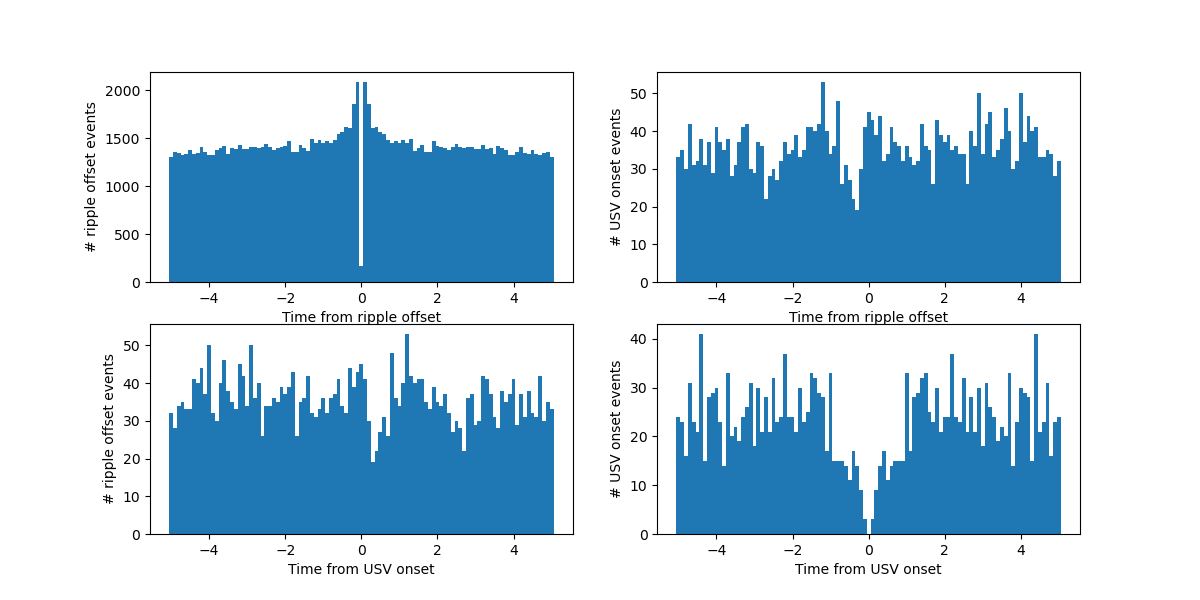

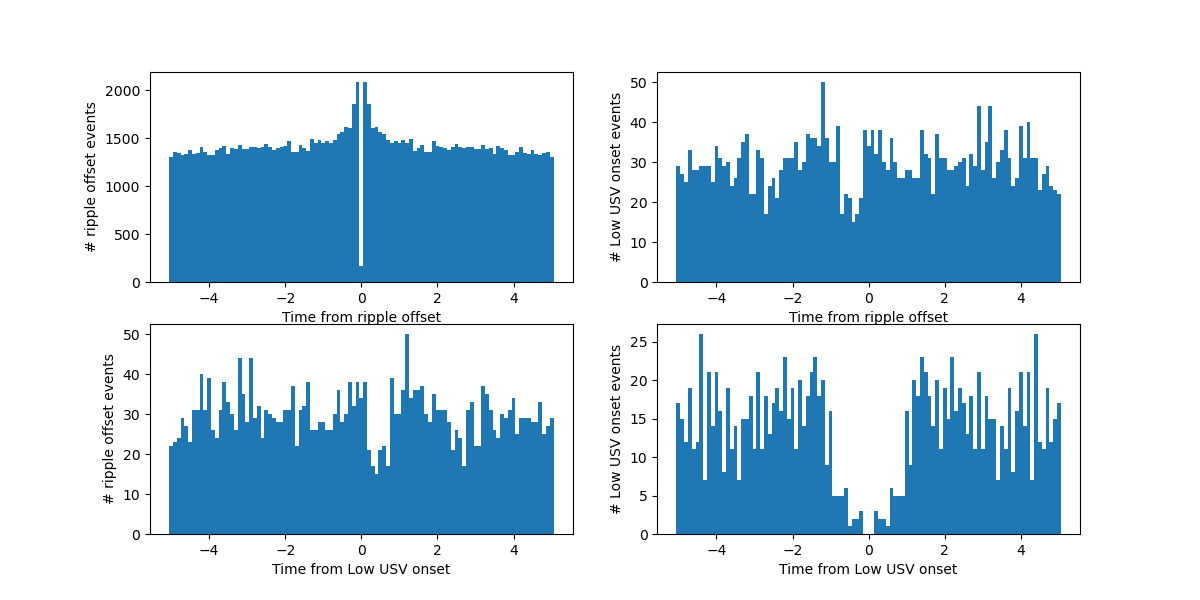

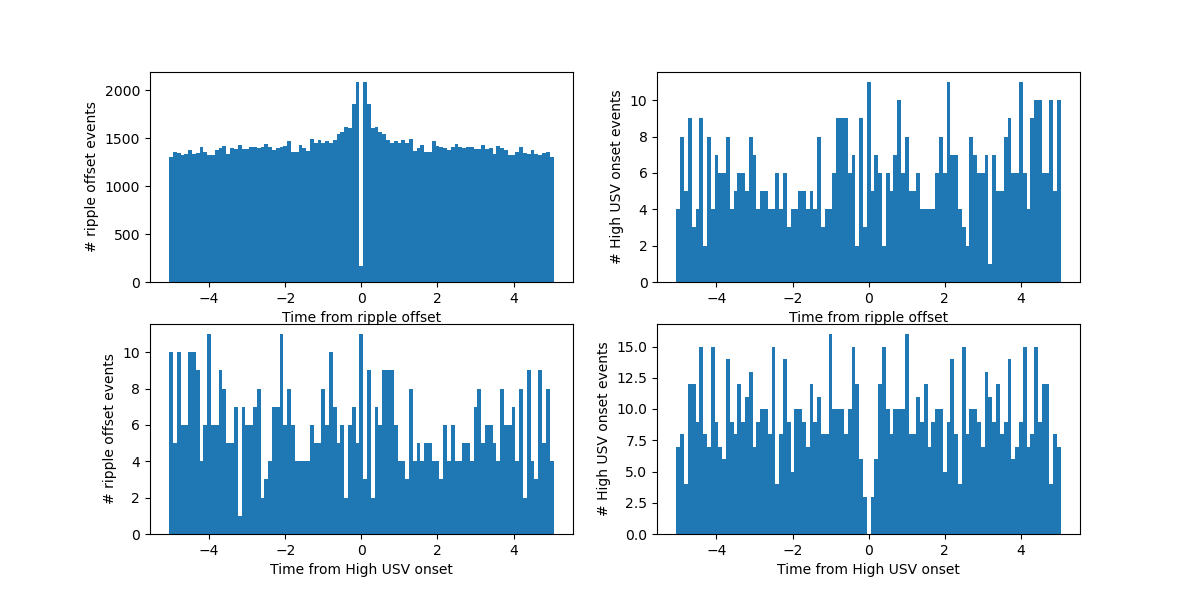

In [80]:
from neuropy.utils.ccg import correlograms

# We observe that right after ripple ends there seem to be a lot of USVs starting - check this by looking at CCG between ripple off and
# USV onset times
ripple_off_usv_on_times = [ripple_epochs.stops, usv_epochs.starts]
ripple_off_usv_on_ids = np.hstack([np.ones_like(array)*ida for ida, array in enumerate(ripple_off_usv_on_times)])
ripple_off_usv_on_times = np.hstack(ripple_off_usv_on_times)
sort_ids = np.argsort(ripple_off_usv_on_times)

ripple_off_usv_on_times = ripple_off_usv_on_times[sort_ids]
ripple_off_usv_on_ids = ripple_off_usv_on_ids[sort_ids].astype(int)

window_size = 10 # seconds
bin_size = 0.1 # seconds
ccg = correlograms(ripple_off_usv_on_times, ripple_off_usv_on_ids, sample_rate=30, window_size=window_size, bin_size=bin_size)
# Sample plotting code
time_bins = np.linspace(-window_size/2, window_size/2, np.array(window_size/bin_size + 1, dtype=int))
corr4_fig, ax = plt.subplots(2, 2, figsize=(12, 6))

var_names = ['ripple offset', 'USV onset']
for idv, (a, ccg_use) in enumerate(zip(ax, ccg)):
    for ida2, (a2, ccg_use2) in enumerate(zip(a, ccg_use)): 
        a2.bar(time_bins, ccg_use2, width=bin_size)
        a2.set_xlabel(f"Time from {var_names[idv]}")
        a2.set_ylabel(f"# {var_names[ida2]} events")
corr4_fig.savefig('/home/bowenw/Documents/thesisplots/Finn2 usv-ripple ccg all.png')

#low usv
from neuropy.utils.ccg import correlograms

# We observe that right after ripple ends there seem to be a lot of USVs starting - check this by looking at CCG between ripple off and
# USV onset times
ripple_off_lowusv_on_times = [ripple_epochs.stops, lowusv_epochs.start]
ripple_off_lowusv_on_ids = np.hstack([np.ones_like(array)*ida for ida, array in enumerate(ripple_off_lowusv_on_times)])
ripple_off_lowusv_on_times = np.hstack(ripple_off_lowusv_on_times)
sort_ids = np.argsort(ripple_off_lowusv_on_times)

ripple_off_lowusv_on_times = ripple_off_lowusv_on_times[sort_ids]
ripple_off_lowusv_on_ids = ripple_off_lowusv_on_ids[sort_ids].astype(int)

window_size = 10 # seconds
bin_size = 0.1 # seconds
ccg = correlograms(ripple_off_lowusv_on_times, ripple_off_lowusv_on_ids, sample_rate=30, window_size=window_size, bin_size=bin_size)
# Sample plotting code, low_usv
time_bins = np.linspace(-window_size/2, window_size/2, np.array(window_size/bin_size + 1, dtype=int))
corr5_fig, ax = plt.subplots(2, 2, figsize=(12, 6))

var_names = ['ripple offset', 'Low USV onset']
for idv, (a, ccg_use) in enumerate(zip(ax, ccg)):
    for ida2, (a2, ccg_use2) in enumerate(zip(a, ccg_use)): 
        a2.bar(time_bins, ccg_use2, width=bin_size)
        a2.set_xlabel(f"Time from {var_names[idv]}")
        a2.set_ylabel(f"# {var_names[ida2]} events")
corr5_fig.savefig('/home/bowenw/Documents/thesisplots/Finn2 usv-ripple ccg lowusv.png')

#high usv
from neuropy.utils.ccg import correlograms

# We observe that right after ripple ends there seem to be a lot of USVs starting - check this by looking at CCG between ripple off and
# USV onset times
ripple_off_highusv_on_times = [ripple_epochs.stops, highusv_epochs.start]
ripple_off_highusv_on_ids = np.hstack([np.ones_like(array)*ida for ida, array in enumerate(ripple_off_highusv_on_times)])
ripple_off_highusv_on_times = np.hstack(ripple_off_highusv_on_times)
sort_ids = np.argsort(ripple_off_highusv_on_times)

ripple_off_highusv_on_times = ripple_off_highusv_on_times[sort_ids]
ripple_off_highusv_on_ids = ripple_off_highusv_on_ids[sort_ids].astype(int)

window_size = 10 # seconds
bin_size = 0.1 # seconds
ccg = correlograms(ripple_off_highusv_on_times, ripple_off_highusv_on_ids, sample_rate=30, window_size=window_size, bin_size=bin_size)
# Sample plotting code, low_usv
time_bins = np.linspace(-window_size/2, window_size/2, np.array(window_size/bin_size + 1, dtype=int))
corr6_fig, ax = plt.subplots(2, 2, figsize=(12, 6))

var_names = ['ripple offset', 'High USV onset']
for idv, (a, ccg_use) in enumerate(zip(ax, ccg)):
    for ida2, (a2, ccg_use2) in enumerate(zip(a, ccg_use)): 
        a2.bar(time_bins, ccg_use2, width=bin_size)
        a2.set_xlabel(f"Time from {var_names[idv]}")
        a2.set_ylabel(f"# {var_names[ida2]} events")
corr6_fig.savefig('/home/bowenw/Documents/thesisplots/Finn2 usv-ripple ccg highusv.png')